(mmm_multidimensional_example)=
# MMM Multidimensional Example Notebook

In this notebook, we present an new experimental media mix model class to create multidimensional and customized marketing mix models. To showcase its capabilities, we extend the {ref}`mmm_example` simulation to create a multidimensional hierarchical model.

```{warning}
Even though the new {class}`MMM <pymc_marketing.mmm.multidimensional.MMM>` class is an experimental class, it is fully functional and can be used to create multidimensional marketing mix models. This model is under active development and will be further improved in the future (feedback welcome!).
```

## Prepare Notebook


In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.additive_effect import LinearTrendEffect
from pymc_marketing.mmm.linear_trend import LinearTrend
from pymc_marketing.mmm.multidimensional import (
    MMM,
    MultiDimensionalBudgetOptimizerWrapper,
)
from pymc_marketing.paths import data_dir
from pymc_marketing.prior import Prior

warnings.filterwarnings("ignore", category=UserWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 8

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

/home/teemu/repos/pymc-marketing/pymc_marketing/mmm/multidimensional.py:67: FutureWarning: This functionality is experimental and subject to change. If you encounter any issues or have suggestions, please raise them at: https://github.com/pymc-labs/pymc-marketing/issues/new
  warnings.warn(warning_msg, FutureWarning, stacklevel=1)


In [2]:
seed: int = sum(map(ord, "mmm_multidimensional"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Read Data

We read the simulated data from the {ref}`mmm_example`.

In [3]:
data_path = data_dir / "mmm_example.csv"

raw_data_df = pd.read_csv(data_path, parse_dates=["date_week"])

raw_data_df = raw_data_df.rename(columns={"date_week": "date"})

raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179 entries, 0 to 178
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       179 non-null    datetime64[ns]
 1   y          179 non-null    float64       
 2   x1         179 non-null    float64       
 3   x2         179 non-null    float64       
 4   event_1    179 non-null    float64       
 5   event_2    179 non-null    float64       
 6   dayofyear  179 non-null    int64         
 7   t          179 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 11.3 KB


To generate a multidimensional dataset, we simply duplicate and perturb the simulated target data with noise.
We assign the different groups to different *geography*  (geos) levels. We keep the same media variables for both geos.

In [4]:
# Create copies of the original data foo both geos
a_data_df = raw_data_df.copy().assign(geo="geo_a")
b_data_df = raw_data_df.copy().assign(geo="geo_b")

# Add noise to the target variable for the second geo
b_data_df["y"] = b_data_df["y"] + 500 * rng.normal(size=len(b_data_df))

# Concatenate the two datasets
data_df = pd.concat([a_data_df, b_data_df])

data_df.head()

date            y        x1   x2  event_1  event_2  dayofyear  t  \
0 2018-04-02  3984.662237  0.318580  0.0      0.0      0.0         92  0   
1 2018-04-09  3762.871794  0.112388  0.0      0.0      0.0         99  1   
2 2018-04-16  4466.967388  0.292400  0.0      0.0      0.0        106  2   
3 2018-04-23  3864.219373  0.071399  0.0      0.0      0.0        113  3   
4 2018-04-30  4441.625278  0.386745  0.0      0.0      0.0        120  4   

     geo  
0  geo_a  
1  geo_a  
2  geo_a  
3  geo_a  
4  geo_a

Let's plot the target variable for each geo to visually inspect the difference.

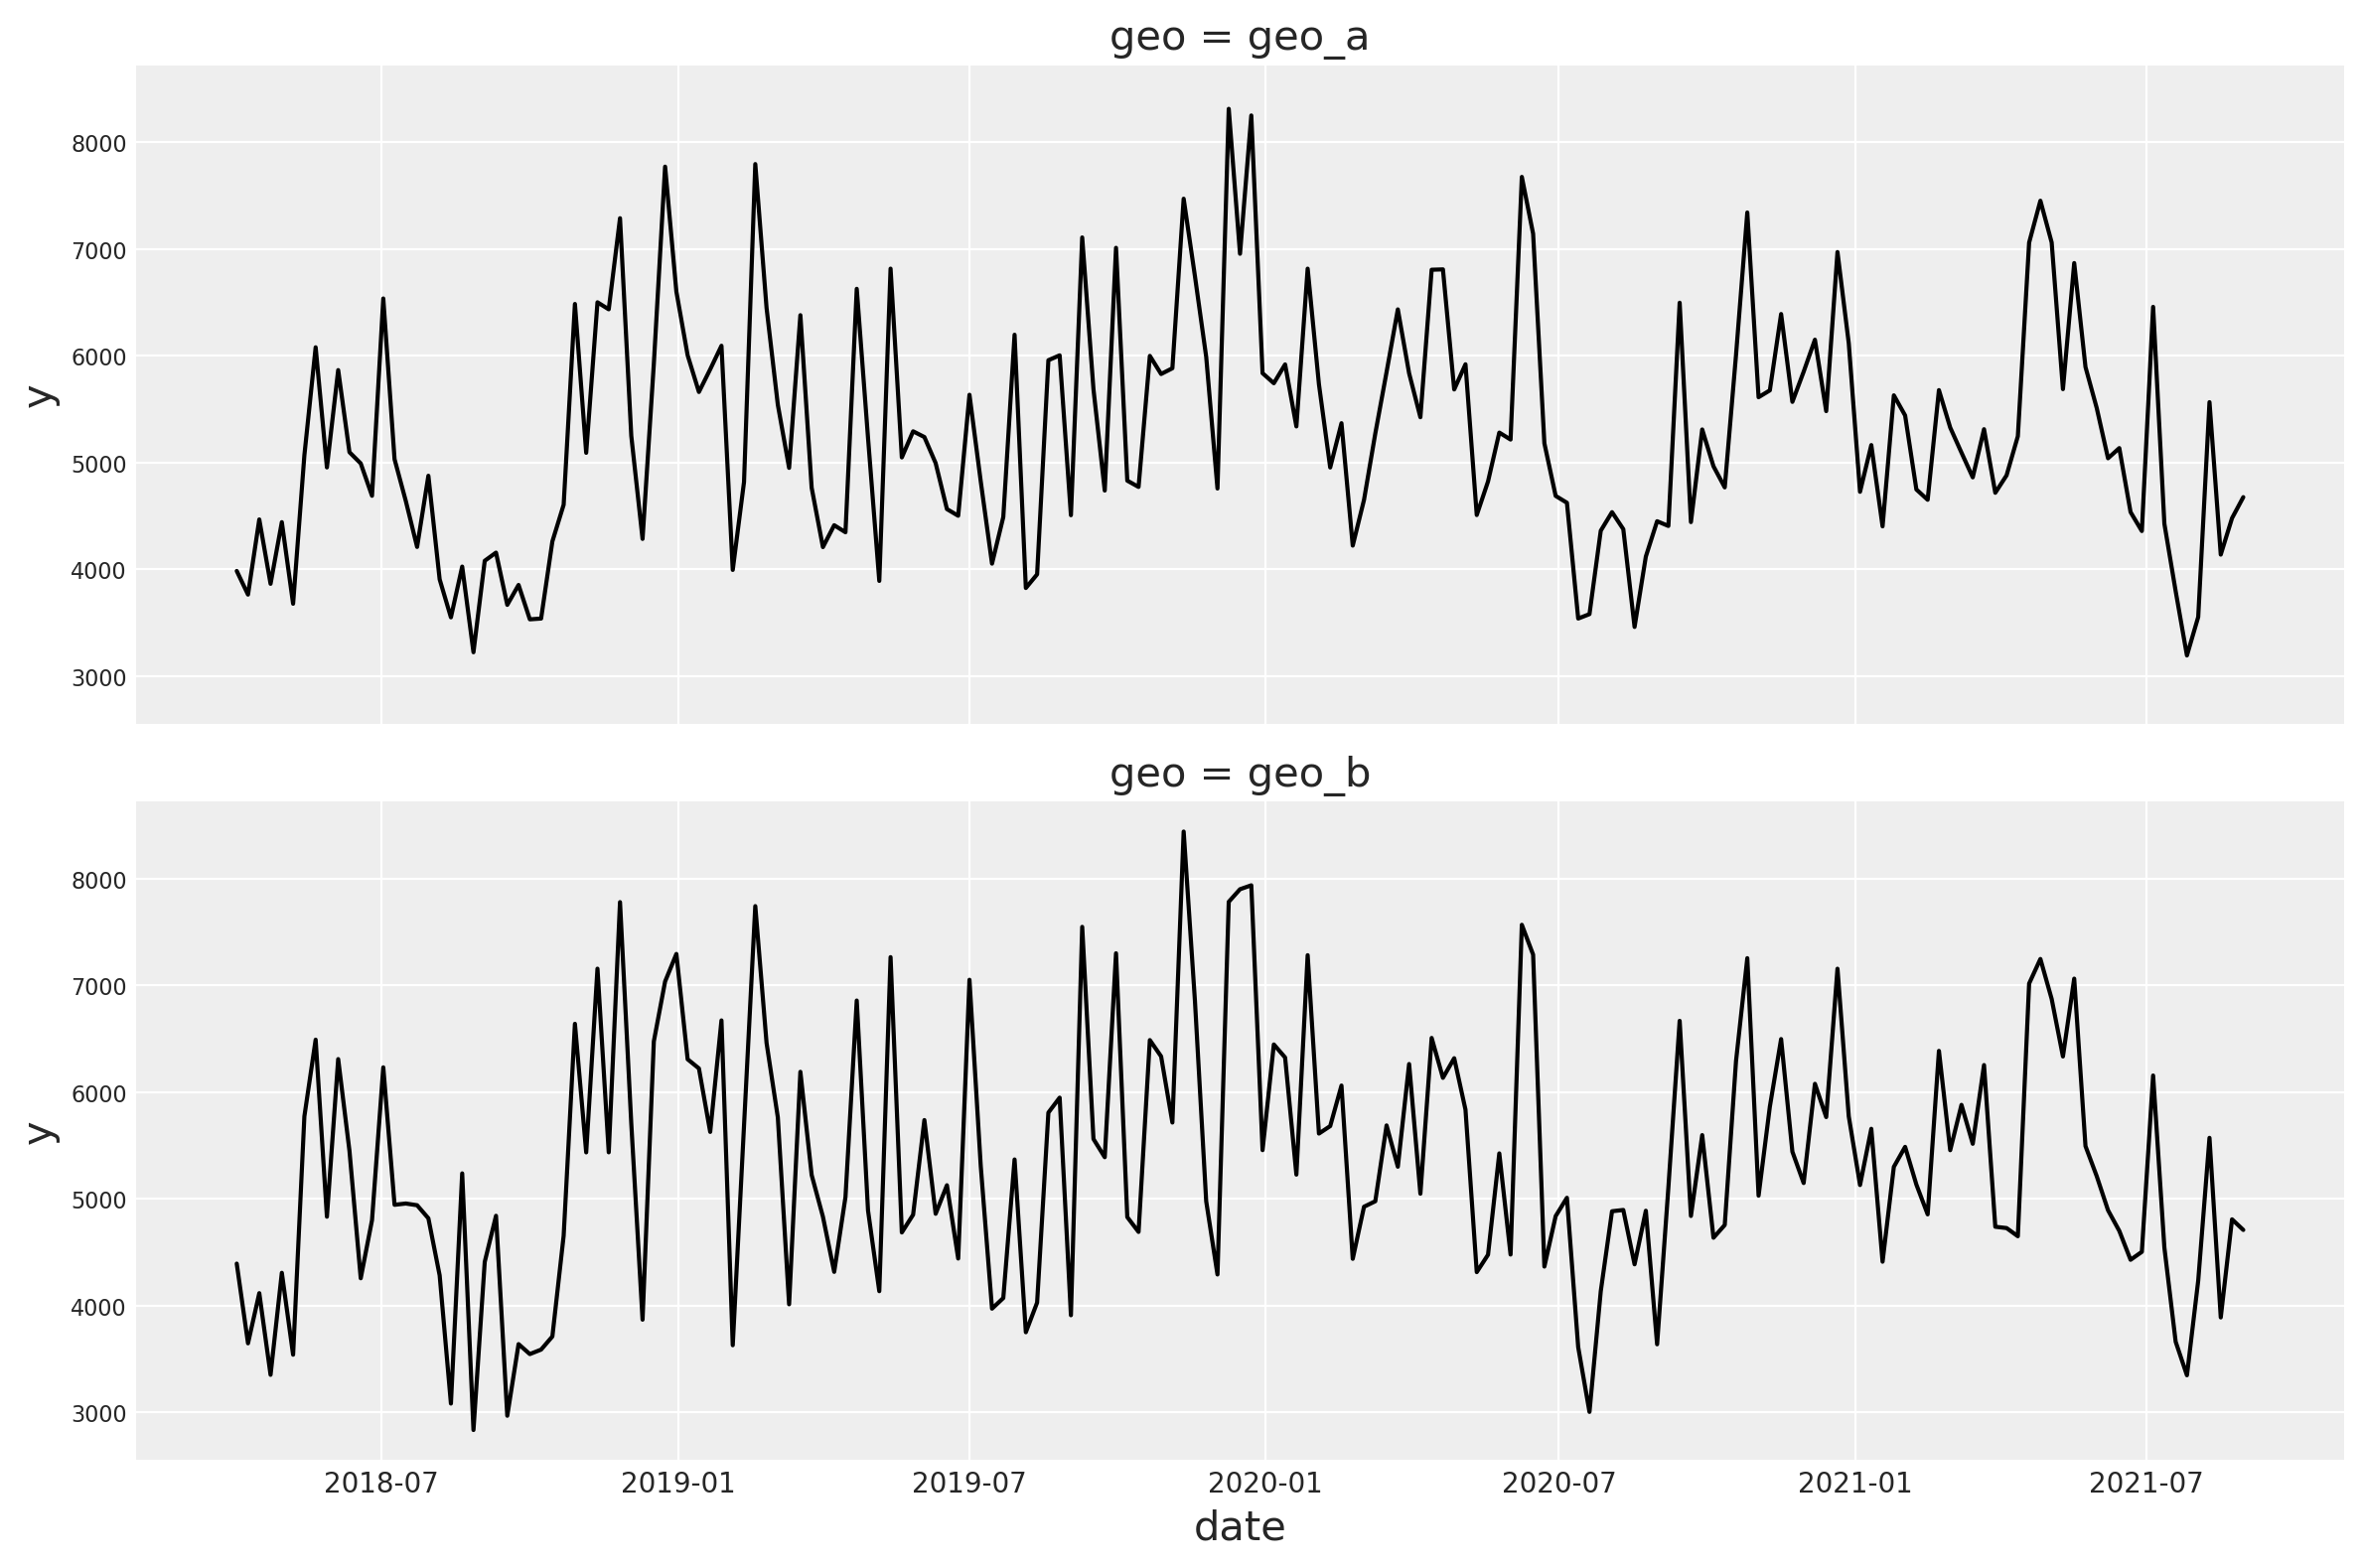

In [5]:
g = sns.relplot(
    data=data_df,
    x="date",
    y="y",
    color="black",
    col="geo",
    col_wrap=1,
    kind="line",
    height=4,
    aspect=3,
)

Overall, the targets follow a similar global pattern but the short term fluctuations are different.

## Prior Specification

Here is where we see the main power of the new class. We can now specify different priors for different geos and even build custom hierarchies.

Recall from the {ref}`mmm_example` that we wan to use the spend shares as a prior for the beta parameters in the saturation function. Let's compute those shares across geos.

In [6]:
channel_columns = ["x1", "x2"]
n_channels = len(channel_columns)

sum_spend_geo_channel = data_df.groupby(["geo"]).agg({"x1": "sum", "x2": "sum"})

spend_share = (
    sum_spend_geo_channel.to_numpy() / sum_spend_geo_channel.sum(axis=1).to_numpy()
)

prior_sigma = n_channels * spend_share

Now we are ready to specify the priors for the saturation function.

For the beta parameters, we use a half-normal distribution with a sigma parameter that is computed as a function of the spend shares. For illustrative purposes, we define the beta values to be independent across both channels and geos.

For the lambda parameters, we add a channel-level hierarchical structure through the hyperparameters of the gamma prior (mu and sigma). These hyperparameters vary by channel, while the lambda values themselves vary across both channel and geo. This setup enables partial pooling across geos within the same channel, allowing the model to share information across geos.

If you need an introduction on Bayesian hierarchical models, check out the comprehensive example ["A Primer on Bayesian Methods for Multilevel Modeling"](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/multilevel_modeling.html) in the PyMC documentation. Please note the `dims` argument in the priors is used to specify the dimensions of the distribution. Here you can control the dimensions along which the hierarchies are defined.

In [7]:
saturation = LogisticSaturation(
    priors={
        "beta": Prior("HalfNormal", sigma=prior_sigma, dims=("channel", "geo")),
        "lam": Prior(
            "Gamma",
            mu=Prior("LogNormal", mu=np.log(3), sigma=np.log(1.5), dims="channel"),
            sigma=Prior("LogNormal", mu=np.log(1), sigma=np.log(1.5), dims="channel"),
            dims=("channel", "geo"),
        ),
    }
)

saturation.model_config

{'saturation_lam': Prior("Gamma", mu=Prior("LogNormal", mu=1.0986122886681098, sigma=0.4054651081081644, dims="channel"), sigma=Prior("LogNormal", mu=0.0, sigma=0.4054651081081644, dims="channel"), dims=("channel", "geo")),
 'saturation_beta': Prior("HalfNormal", sigma=[[1.31263903 0.68736097]
  [1.31263903 0.68736097]], dims=("channel", "geo"))}

For the adstock parameters we do not add any hierarchical structure. We simply keep the same prior for all the geos.

In [8]:
adstock = GeometricAdstock(
    priors={"alpha": Prior("Beta", alpha=2, beta=3, dims="channel")}, l_max=8
)

adstock.model_config

{'adstock_alpha': Prior("Beta", alpha=2, beta=3, dims="channel")}

We complete the model specification with similar priors as in the {ref}`mmm_example`. Please be aware on how to specify the priors dimensions.

In [9]:
model_config = {
    "intercept": Prior("Normal", mu=0.5, sigma=0.5, dims="geo"),
    "gamma_control": Prior("Normal", mu=0, sigma=0.5, dims="control"),
    "gamma_fourier": Prior(
        "Laplace", mu=0, b=Prior("HalfNormal", sigma=0.2), dims=("geo", "fourier_mode")
    ),
    "likelihood": Prior(
        "TruncatedNormal",
        lower=0,
        sigma=Prior("HalfNormal", sigma=Prior("HalfNormal", sigma=1.5)),
        dims=("date", "geo"),
    ),
}

## Model Definition

We are now ready to define the model class. The API is very similar to the one in the {ref}`mmm_example`. 

In [10]:
# Base MMM model specification
mmm = MMM(
    date_column="date",
    target_column="y",
    channel_columns=["x1", "x2"],
    control_columns=["event_1", "event_2"],
    dims=("geo",),
    scaling={
        "channel": {"method": "max", "dims": ()},
        "target": {"method": "max", "dims": ()},
    },
    adstock=adstock,
    saturation=saturation,
    yearly_seasonality=2,
    model_config=model_config,
)

```{tip}
Observe we have the following two new arguments:
- `dims`: a tuple of strings that specify the dimensions of the model.
- `scaling`: a dictionary that specifies the scaling method and dimensions for the target  and media variables. In this case we leave the dimensions empty as we want to scale the target variable for each geo (see details below).
```




We can add additional components to the model mean component. Here, for example, we add a hierarchical linear trend component (with changepoints).

In [11]:
linear_trend = LinearTrend(
    priors={
        "delta": Prior(
            "Laplace",
            mu=0,
            b=Prior("HalfNormal", sigma=0.2),
            dims=("changepoint", "geo"),
        ),
    },
    n_changepoints=5,
    include_intercept=False,
    dims=("geo"),
)

linear_trend_effect = LinearTrendEffect(linear_trend, prefix="trend")

mmm.mu_effects.append(linear_trend_effect)

We can now prepare the training data.

In [12]:
x_train = data_df.drop(columns=["y"])

y_train = data_df["y"]

To build the model, we need to specify the training data and the target variables.

```{tip}
We do not need to build the model, we can simply fit the model. This is just to inspect the model structure.
```

In [13]:
mmm.build_model(X=x_train, y=y_train)

Let's look into the model graph:

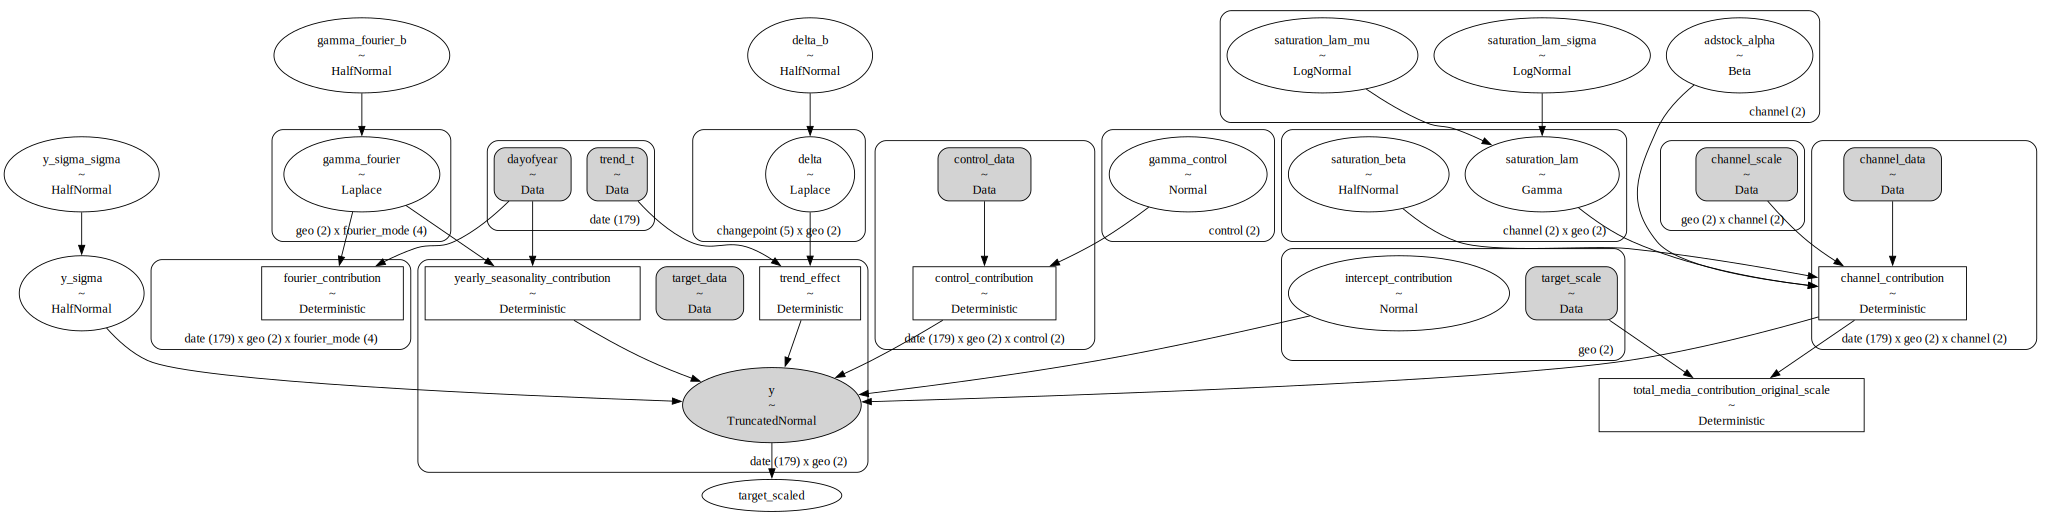

In [14]:
pm.model_to_graphviz(mmm.model)

It is great to see that the model automatically vectorizes and creates the expected hierarchies and dimensions 🚀!

As we are scaling our data internally, we can add deterministic terms to recover the component contributions in the original scale.

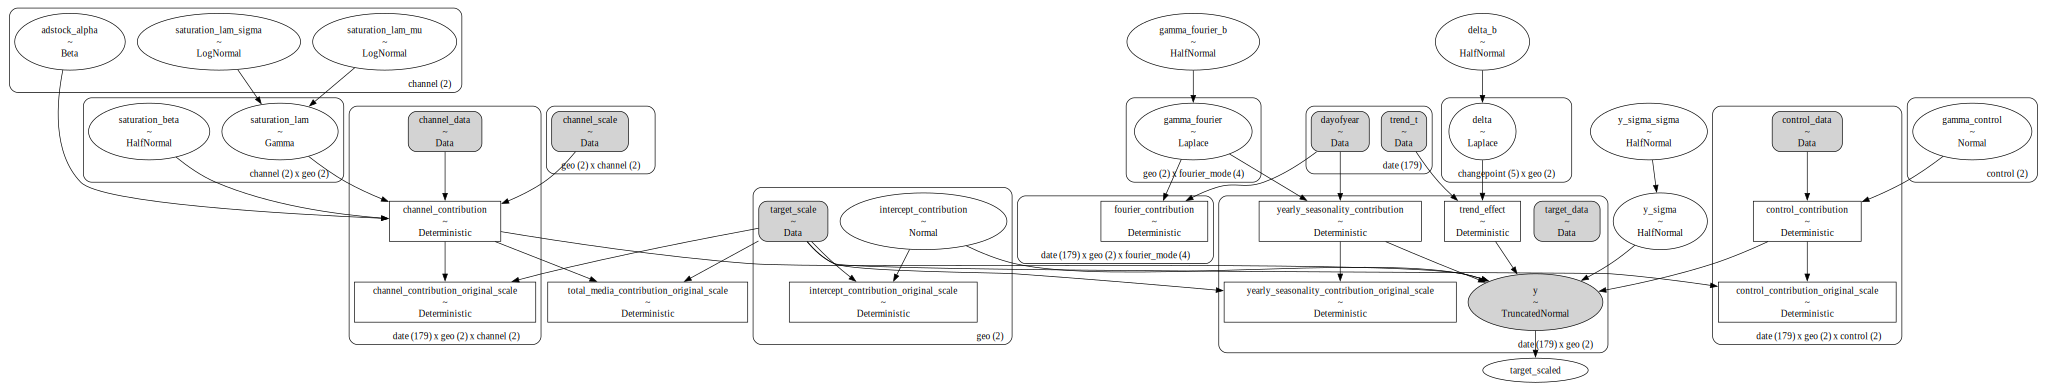

In [15]:
mmm.add_original_scale_contribution_variable(
    var=[
        "channel_contribution",
        "control_contribution",
        "intercept_contribution",
        "yearly_seasonality_contribution",
    ]
)

pm.model_to_graphviz(mmm.model)

Coming back to the scalers, we can get them as an xarray dataset.

In [16]:
scalers = mmm.get_scales_as_xarray()

scalers

{'channel_scale': <xarray.DataArray '_channel' (geo: 2, channel: 2)> Size: 32B
 array([[0.99665813, 0.99437431],
        [0.99665813, 0.99437431]])
 Coordinates:
   * geo      (geo) object 16B 'geo_a' 'geo_b'
   * channel  (channel) object 16B 'x1' 'x2',
 'target_scale': <xarray.DataArray '_target' (geo: 2)> Size: 16B
 array([8312.40754439, 8440.6617456 ])
 Coordinates:
   * geo      (geo) object 16B 'geo_a' 'geo_b'}

As expected, from the model definition, we have scalers for the target and media variables across geos.

## Prior Predictive Checks

Before fitting the model, we can inspect the prior predictive distribution.

In [17]:
prior_predictive = mmm.sample_prior_predictive(X=x_train, y=y_train, samples=1_000)

Sampling: [adstock_alpha, delta, delta_b, gamma_control, gamma_fourier, gamma_fourier_b, intercept_contribution, saturation_beta, saturation_lam, saturation_lam_mu, saturation_lam_sigma, y, y_sigma, y_sigma_sigma]


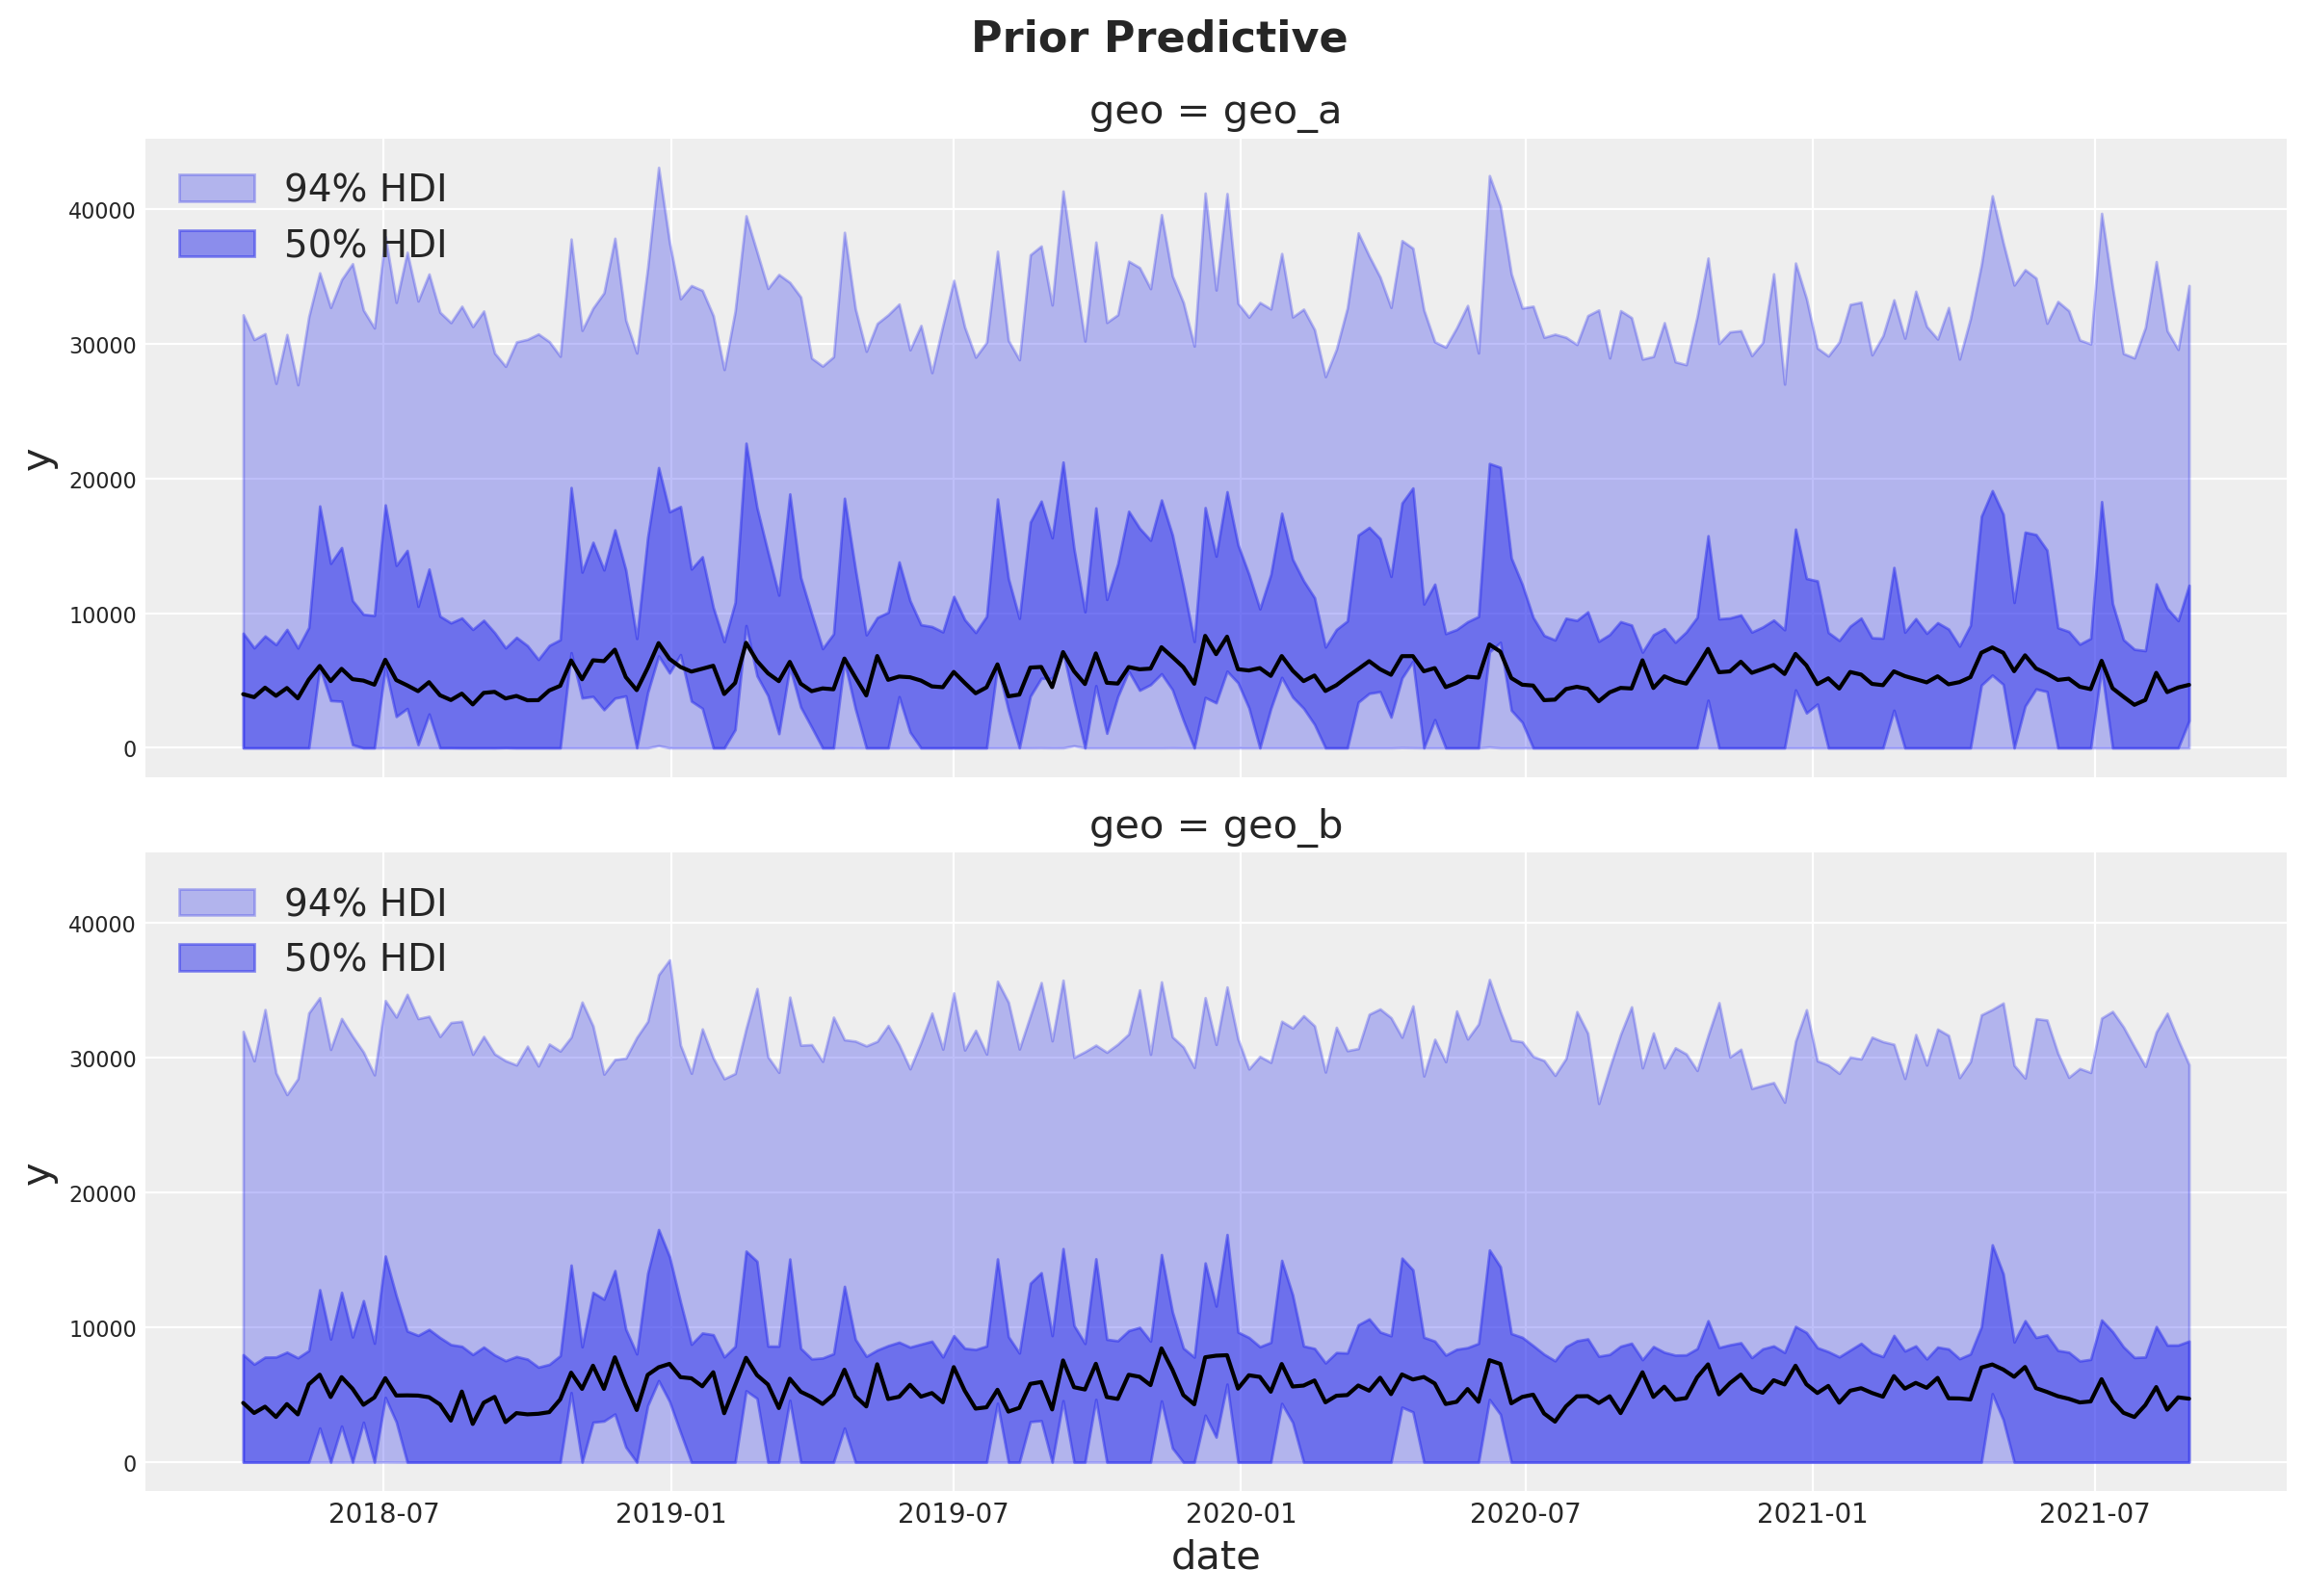

In [18]:
g = sns.relplot(
    data=data_df,
    x="date",
    y="y",
    color="black",
    col="geo",
    col_wrap=1,
    kind="line",
    height=4,
    aspect=3,
)

axes = g.axes.flatten()

for ax, geo in zip(axes, mmm.model.coords["geo"], strict=True):
    az.plot_hdi(
        x=mmm.model.coords["date"],
        # We need to scale the prior predictive to the original scale to make it comparable to the data.
        y=(
            prior_predictive.sel(geo=geo)["y"].unstack().transpose(..., "date")
            * scalers["target_scale"].sel(geo=geo).item()
        ),
        smooth=False,
        color="C0",
        hdi_prob=0.94,
        fill_kwargs={"alpha": 0.3, "label": "94% HDI"},
        ax=ax,
    )
    az.plot_hdi(
        x=mmm.model.coords["date"],
        y=(
            prior_predictive.sel(geo=geo)["y"].unstack().transpose(..., "date")
            * scalers["target_scale"].sel(geo=geo).item()
        ),
        smooth=False,
        color="C0",
        hdi_prob=0.5,
        fill_kwargs={"alpha": 0.5, "label": "50% HDI"},
        ax=ax,
    )
    ax.legend(loc="upper left")

g.figure.suptitle("Prior Predictive", fontsize=16, fontweight="bold", y=1.03);

The prior predictive distribution looks good and not too restrictive.

## Model Fitting

We can now fit the model and generate the posterior predictive distribution.

In [19]:
mmm.fit(
    X=x_train,
    y=y_train,
    chains=4,
    target_accept=0.8,
    nuts_sampler="nutpie",
    random_seed=rng,
)

mmm.sample_posterior_predictive(
    X=x_train,
    extend_idata=True,
    combined=True,
    random_seed=rng,
)

Sampling: [y]


Output()

<xarray.Dataset> Size: 12MB
Dimensions:  (date: 179, geo: 2, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 1kB 2018-04-02 2018-04-09 ... 2021-08-30
  * geo      (geo) <U5 40B 'geo_a' 'geo_b'
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int64 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 32kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, geo, sample) float64 11MB 0.479 0.5056 ... 0.5873 0.6059
Attributes:
    created_at:                 2025-05-21T08:56:47.182187+00:00
    arviz_version:              0.21.0
    inference_library:          pymc
    inference_library_version:  5.22.0

The sampling looks good, no divergences and the r-hat values are close to $1$.

In [20]:
mmm.idata.sample_stats.diverging.sum().item()

In [21]:
az.summary(
    mmm.idata,
    var_names=[
        "adstock_alpha",
        "delta",
        "delta_b",
        "gamma_control",
        "gamma_fourier",
        "intercept_contribution",
        "saturation_beta",
        "saturation_lam_mu",
        "saturation_lam_sigma",
        "saturation_lam",
        "y_sigma_sigma",
        "y_sigma",
    ],
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
adstock_alpha[x1]              0.398  0.033   0.339    0.463      0.001   
adstock_alpha[x2]              0.173  0.042   0.094    0.252      0.001   
delta[0, geo_a]                0.108  0.050   0.001    0.193      0.002   
delta[0, geo_b]                0.101  0.049   0.004    0.193      0.001   
delta[1, geo_a]                0.021  0.065  -0.100    0.153      0.002   
delta[1, geo_b]                0.011  0.062  -0.108    0.137      0.002   
delta[2, geo_a]               -0.041  0.060  -0.159    0.064      0.002   
delta[2, geo_b]               -0.028  0.058  -0.148    0.069      0.001   
delta[3, geo_a]                0.011  0.066  -0.116    0.140      0.001   
delta[3, geo_b]                0.031  0.072  -0.088    0.181      0.001   
delta[4, geo_a]               -0.003  0.125  -0.262    0.223      0.002   
delta[4, geo_b]               -0.000  0.128  -0.227    0.276      0.002   
delta_b                        0.080  0.040   0.022    0.155      0.001   
gamma_control[event_1]         0.272  0.034   0.210    0.338      0.000   
gamma_control[event_2]         0.326  0.037   0.255    0.394      0.000   
gamma_fourier[geo_a, sin_1]    0.003  0.005  -0.006    0.013      0.000   
gamma_fourier[geo_a, sin_2]   -0.057  0.005  -0.067   -0.047      0.000   
gamma_fourier[geo_a, cos_1]    0.062  0.005   0.053    0.072      0.000   
gamma_fourier[geo_a, cos_2]    0.002  0.005  -0.008    0.011      0.000   
gamma_fourier[geo_b, sin_1]    0.001  0.005  -0.008    0.012      0.000   
gamma_fourier[geo_b, sin_2]   -0.044  0.005  -0.055   -0.034      0.000   
gamma_fourier[geo_b, cos_1]    0.068  0.005   0.057    0.077      0.000   
gamma_fourier[geo_b, cos_2]    0.001  0.005  -0.009    0.010      0.000   
intercept_contribution[geo_a]  0.354  0.020   0.315    0.389      0.001   
intercept_contribution[geo_b]  0.350  0.020   0.313    0.386      0.000   
saturation_beta[x1, geo_a]     0.367  0.029   0.315    0.425      0.001   
saturation_beta[x1, geo_b]     0.384  0.029   0.332    0.440      0.001   
saturation_beta[x2, geo_a]     0.293  0.184   0.184    0.484      0.008   
saturation_beta[x2, geo_b]     0.275  0.124   0.173    0.448      0.005   
saturation_lam_mu[x1]          3.812  0.743   2.458    5.204      0.015   
saturation_lam_mu[x2]          3.045  1.013   1.278    4.802      0.031   
saturation_lam_sigma[x1]       0.942  0.369   0.348    1.608      0.006   
saturation_lam_sigma[x2]       1.013  0.397   0.392    1.783      0.007   
saturation_lam[x1, geo_a]      3.904  0.569   2.806    4.957      0.014   
saturation_lam[x1, geo_b]      3.976  0.536   2.960    4.997      0.014   
saturation_lam[x2, geo_a]      3.125  1.334   0.659    5.479      0.048   
saturation_lam[x2, geo_b]      2.814  1.156   0.671    4.877      0.040   
y_sigma_sigma                  0.517  0.626   0.013    1.742      0.010   
y_sigma                        0.049  0.002   0.045    0.053      0.000   

                               mcse_sd  ess_bulk  ess_tail  r_hat  
adstock_alpha[x1]                0.000    3194.0    2895.0   1.00  
adstock_alpha[x2]                0.001    1353.0    2273.0   1.00  
delta[0, geo_a]                  0.001    1007.0    1115.0   1.01  
delta[0, geo_b]                  0.001    1118.0    1404.0   1.00  
delta[1, geo_a]                  0.002     999.0    1136.0   1.01  
delta[1, geo_b]                  0.002    1066.0    1095.0   1.00  
delta[2, geo_a]                  0.001    1883.0    1673.0   1.00  
delta[2, geo_b]                  0.001    1952.0    1987.0   1.00  
delta[3, geo_a]                  0.002    3199.0    2222.0   1.00  
delta[3, geo_b]                  0.002    3408.0    2280.0   1.00  
delta[4, geo_a]                  0.006    4584.0    1598.0   1.00  
delta[4, geo_b]                  0.007    4261.0    1922.0   1.01  
delta_b                          0.001    1139.0    1931.0   1.00  
gamma_control[event_1]           0.001    5211.0    3118.0   1.00  
gamma_contr

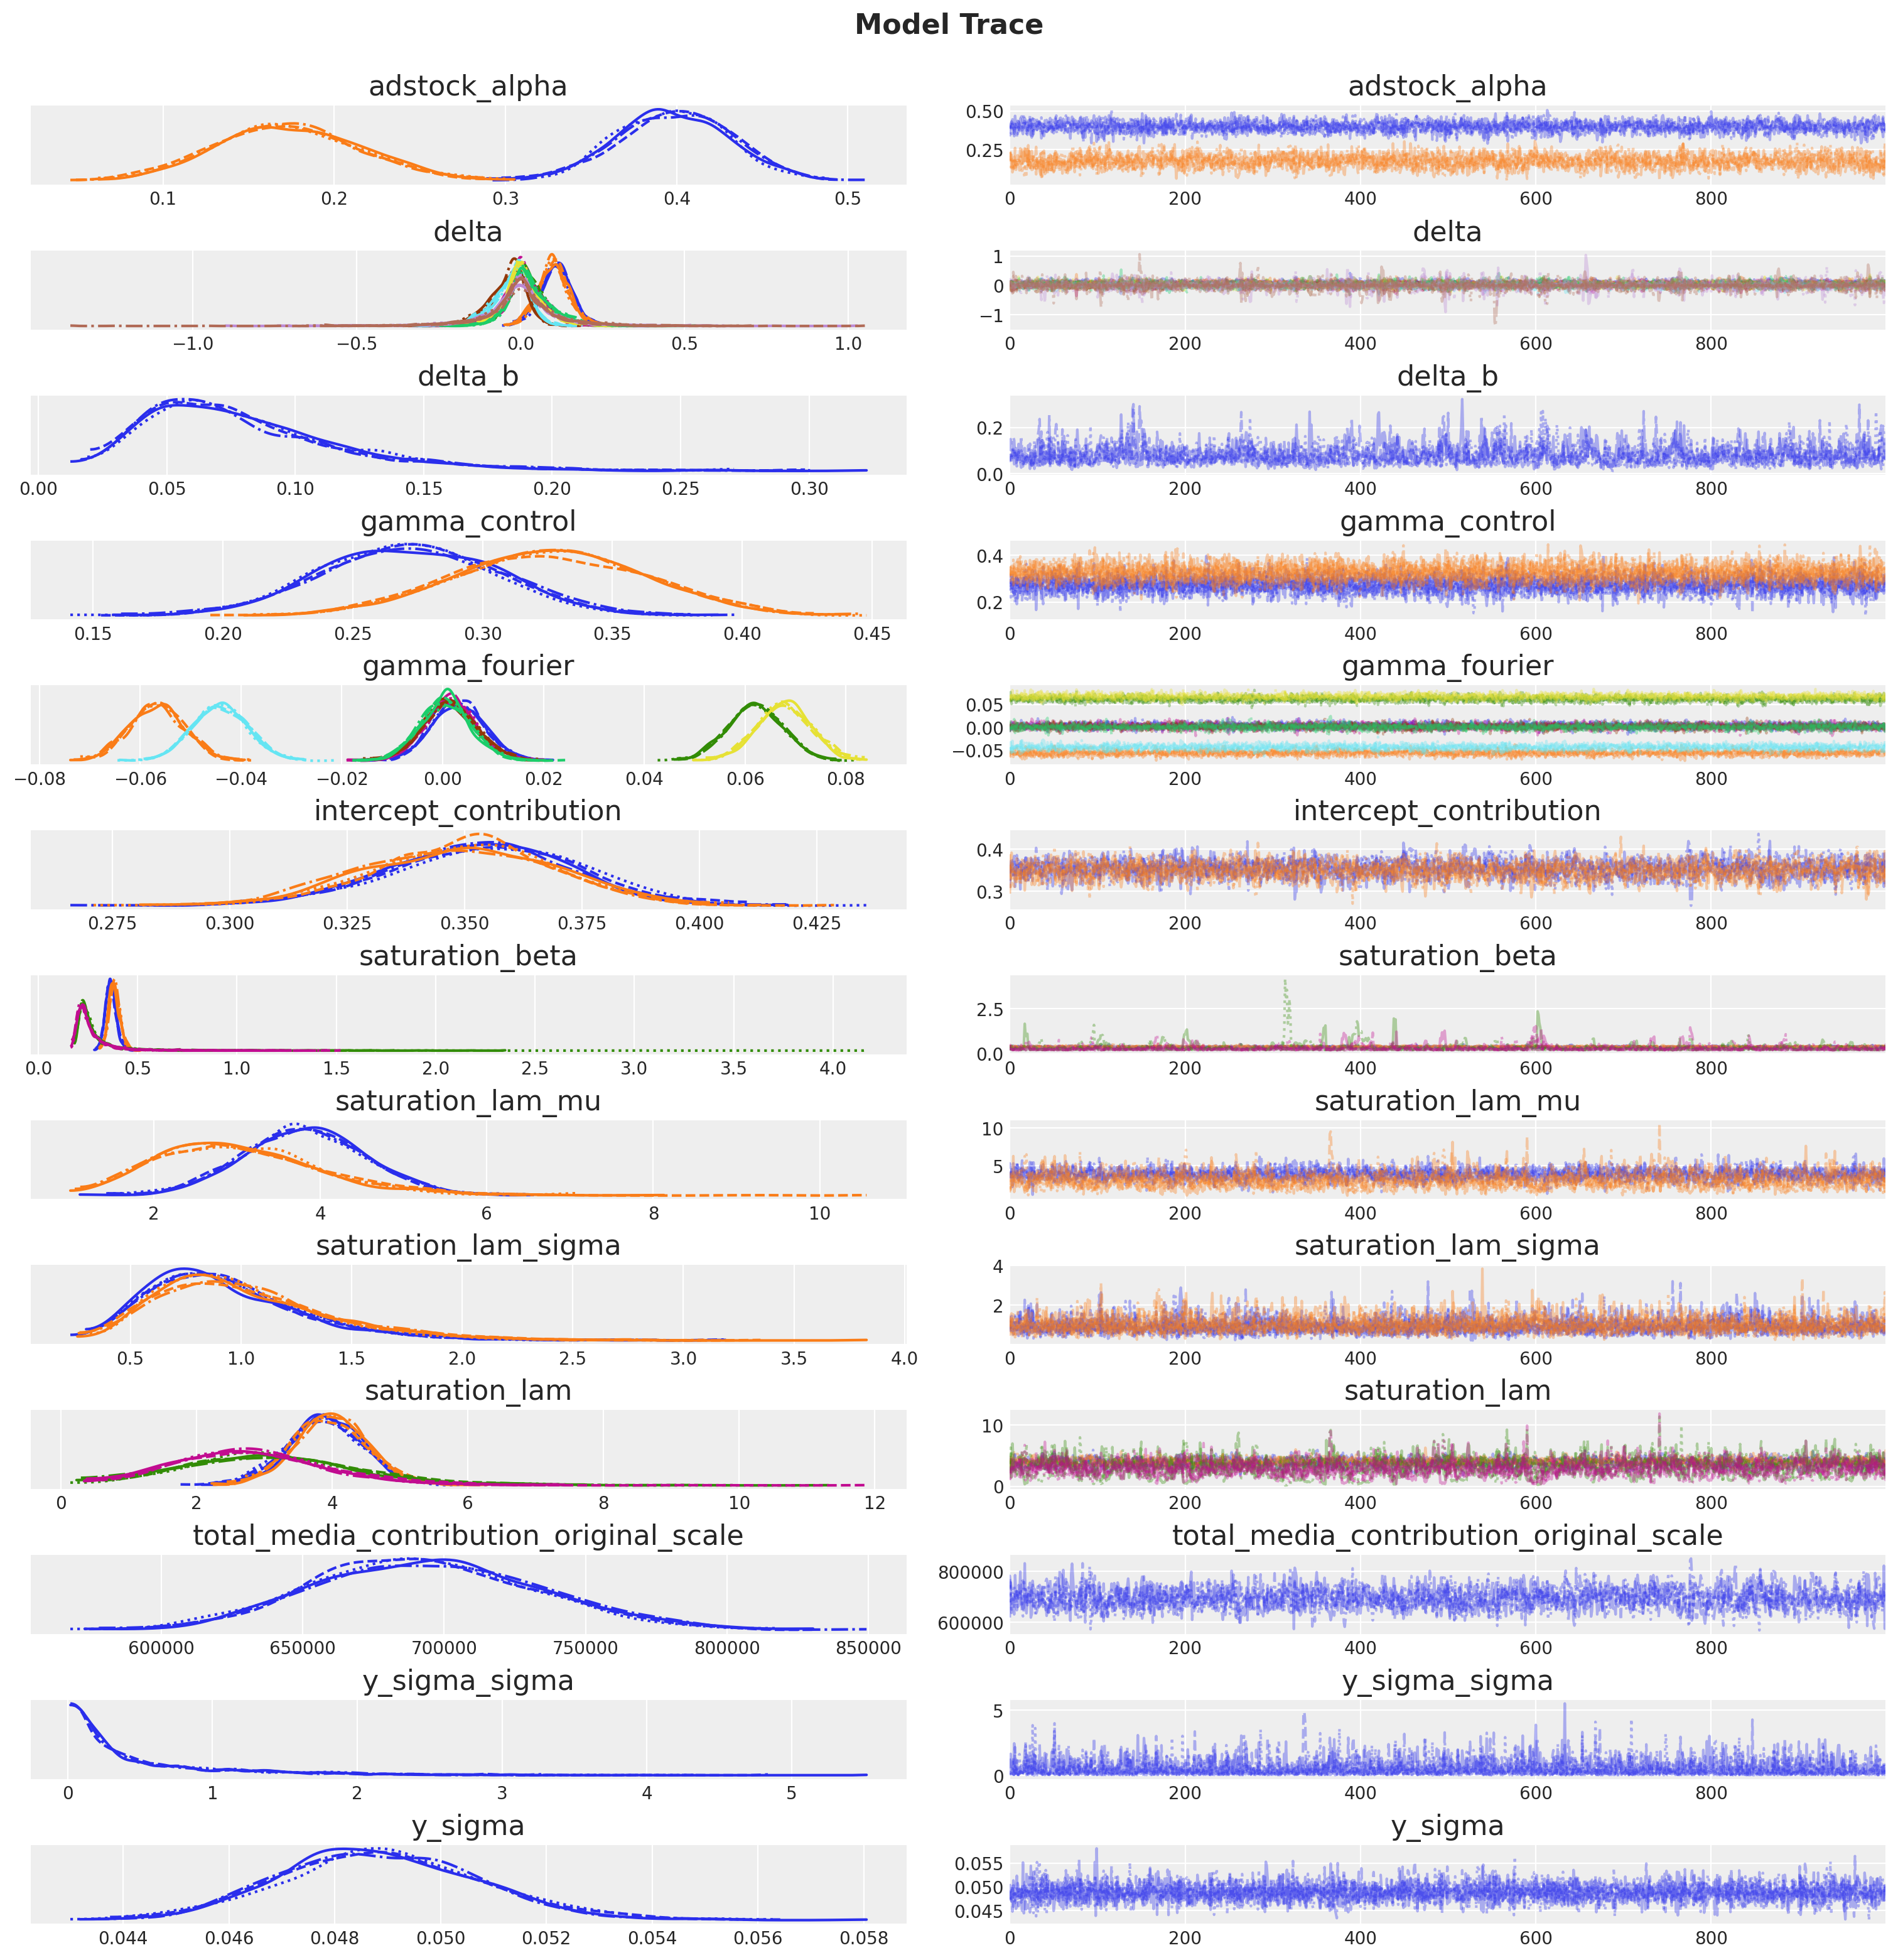

In [22]:
_ = az.plot_trace(
    data=mmm.fit_result,
    var_names=[
        "adstock_alpha",
        "delta",
        "delta_b",
        "gamma_control",
        "gamma_fourier",
        "intercept_contribution",
        "saturation_beta",
        "saturation_lam_mu",
        "saturation_lam_sigma",
        "saturation_lam",
        "total_media_contribution_original_scale",
        "y_sigma_sigma",
        "y_sigma",
    ],
    compact=True,
    backend_kwargs={"figsize": (15, 15), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16, fontweight="bold", y=1.03);

## Posterior Predictive Checks

We can now inspect the posterior predictive distribution. As before, we need to scale the posterior predictive to the original scale to make it comparable to the data.


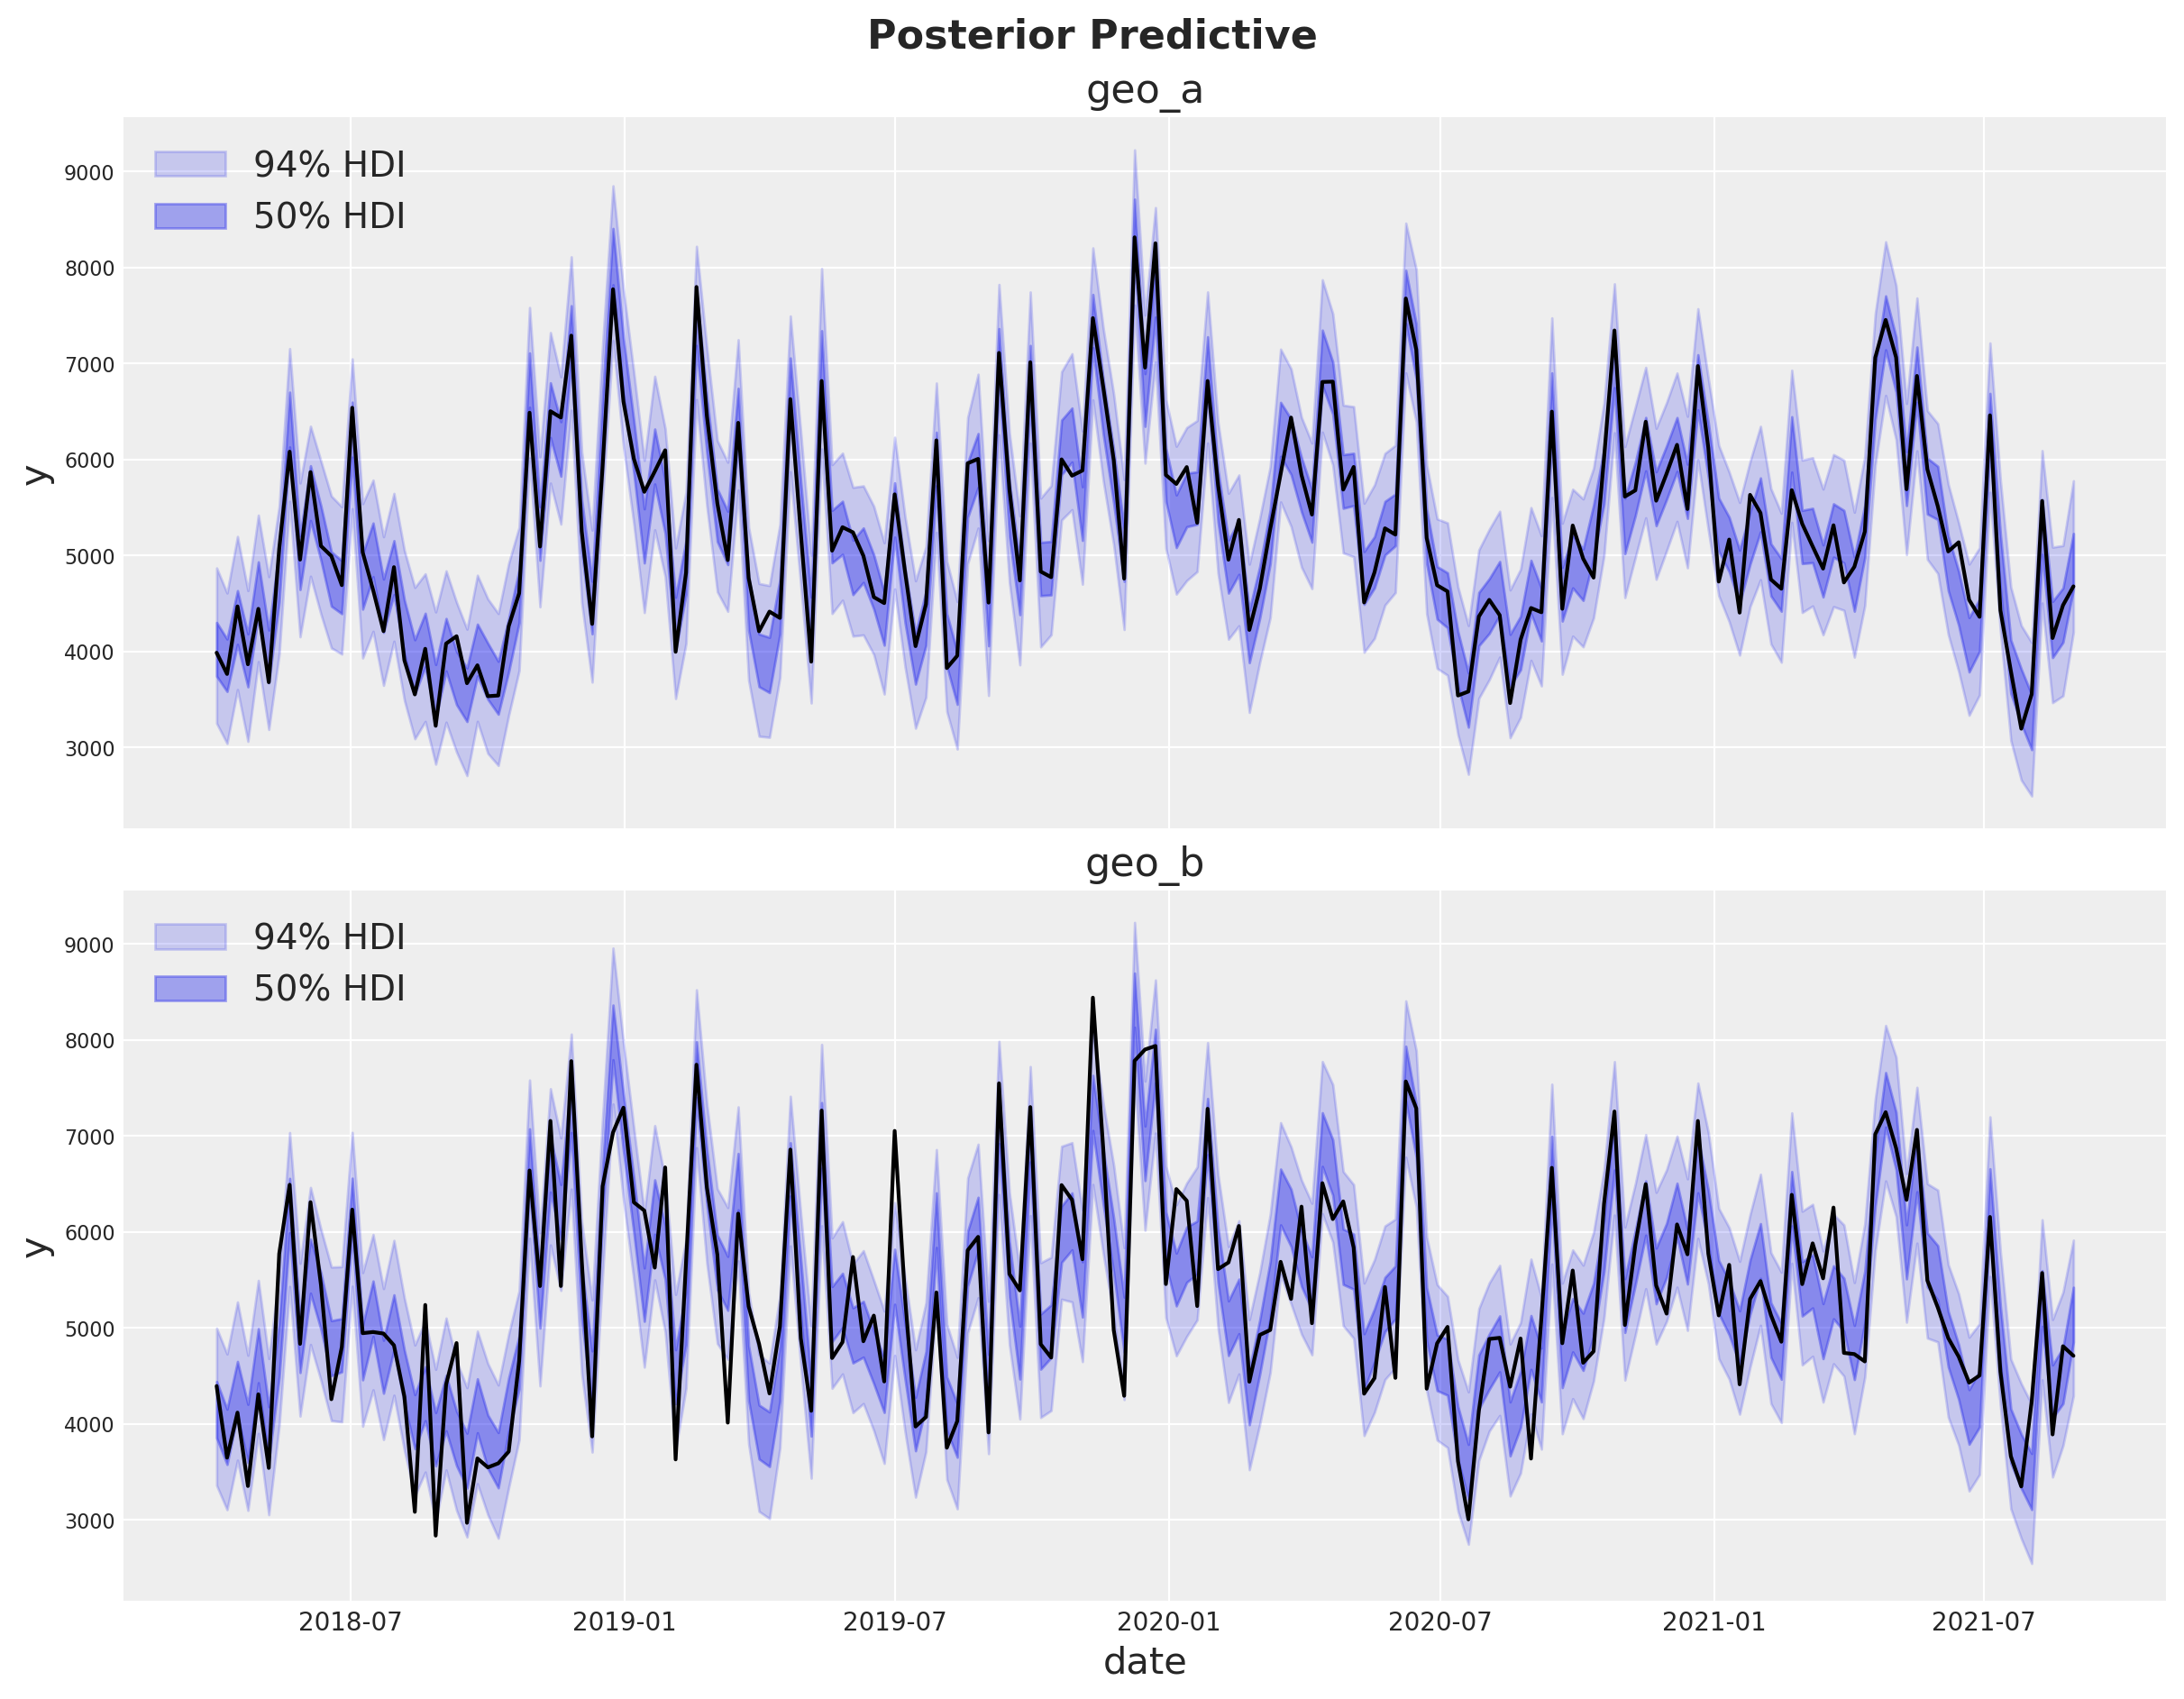

In [23]:
fig, axes = plt.subplots(
    nrows=len(mmm.model.coords["geo"]),
    figsize=(12, 9),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i, geo in enumerate(mmm.model.coords["geo"]):
    ax = axes[i]
    az.plot_hdi(
        x=mmm.model.coords["date"],
        y=(
            mmm.idata["posterior_predictive"].sel(geo=geo)["y"]
            * scalers["target_scale"].sel(geo=geo).item()
        ),
        color="C0",
        smooth=False,
        hdi_prob=0.94,
        fill_kwargs={"alpha": 0.2, "label": "94% HDI"},
        ax=ax,
    )

    az.plot_hdi(
        x=mmm.model.coords["date"],
        y=(
            mmm.idata["posterior_predictive"].sel(geo=geo)["y"]
            * scalers["target_scale"].sel(geo=geo).item()
        ),
        color="C0",
        smooth=False,
        hdi_prob=0.5,
        fill_kwargs={"alpha": 0.4, "label": "50% HDI"},
        ax=ax,
    )

    sns.lineplot(
        data=data_df.query("geo == @geo"),
        x="date",
        y="y",
        color="black",
        ax=ax,
    )

    ax.legend(loc="upper left")
    ax.set(title=f"{geo}")

fig.suptitle("Posterior Predictive", fontsize=16, fontweight="bold", y=1.03);

The fit looks very good!

## Model Components

We can extract the contributions of each component of the model in the original scale thanks to the deterministic variables added to the model.

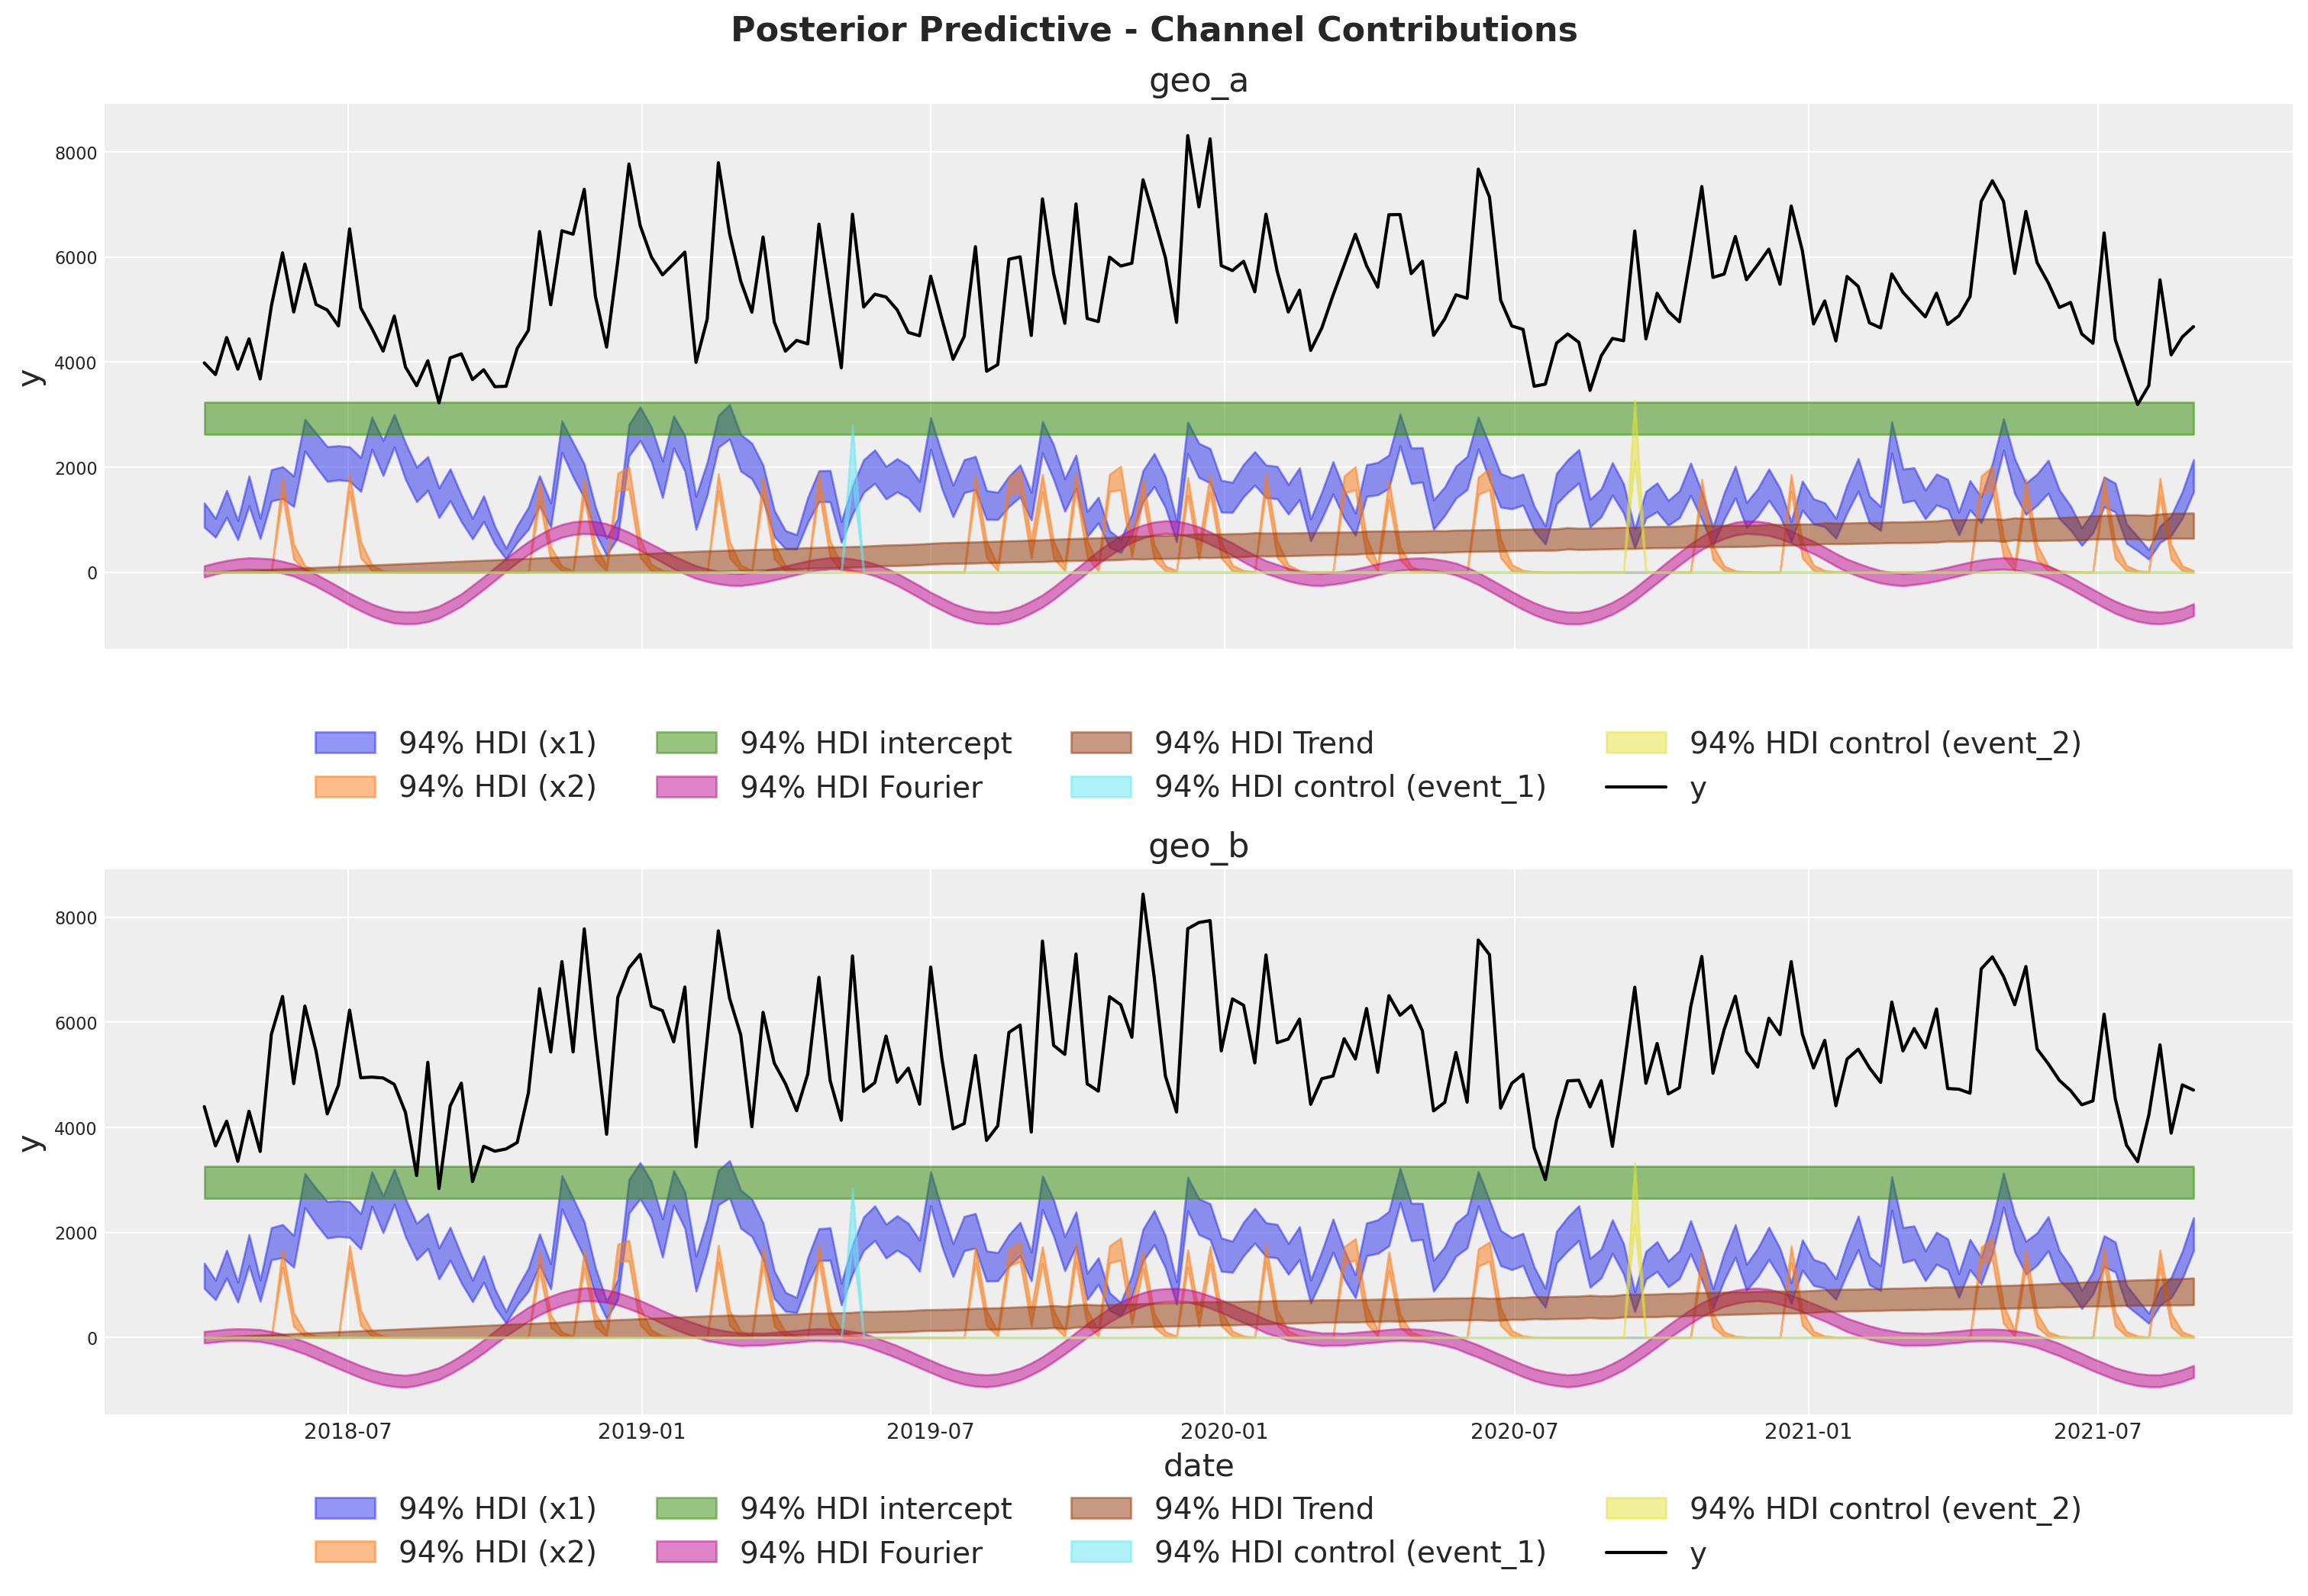

In [24]:
fig, axes = plt.subplots(
    nrows=len(mmm.model.coords["geo"]),
    figsize=(15, 10),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i, geo in enumerate(mmm.model.coords["geo"]):
    ax = axes[i]

    for j, channel in enumerate(mmm.model.coords["channel"]):
        az.plot_hdi(
            x=mmm.model.coords["date"],
            y=mmm.idata["posterior"]["channel_contribution_original_scale"].sel(
                geo=geo, channel=channel
            ),
            color=f"C{j}",
            smooth=False,
            hdi_prob=0.94,
            fill_kwargs={"alpha": 0.5, "label": f"94% HDI ({channel})"},
            ax=ax,
        )

    az.plot_hdi(
        x=mmm.model.coords["date"],
        y=mmm.idata["posterior"]["intercept_contribution_original_scale"]
        .sel(geo=geo)
        .expand_dims({"date": mmm.model.coords["date"]})
        .transpose(..., "date"),
        color="C2",
        smooth=False,
        hdi_prob=0.94,
        fill_kwargs={"alpha": 0.5, "label": "94% HDI intercept"},
        ax=ax,
    )

    az.plot_hdi(
        x=mmm.model.coords["date"],
        y=mmm.idata["posterior"]["yearly_seasonality_contribution_original_scale"].sel(
            geo=geo,
        ),
        color="C3",
        smooth=False,
        hdi_prob=0.94,
        fill_kwargs={"alpha": 0.5, "label": "94% HDI Fourier"},
        ax=ax,
    )

    az.plot_hdi(
        x=mmm.model.coords["date"],
        y=mmm.idata["posterior"]["trend_effect"].sel(
            geo=geo,
        )
        * mmm.scalers["_target"].sel(geo=geo).item(),
        color="C4",
        smooth=False,
        hdi_prob=0.94,
        fill_kwargs={"alpha": 0.5, "label": "94% HDI Trend"},
        ax=ax,
    )

    for k, control in enumerate(mmm.model.coords["control"]):
        az.plot_hdi(
            x=mmm.model.coords["date"],
            y=mmm.idata["posterior"]["control_contribution_original_scale"].sel(
                geo=geo, control=control
            ),
            color=f"C{5 + k}",
            smooth=False,
            hdi_prob=0.94,
            fill_kwargs={"alpha": 0.5, "label": f"94% HDI control ({control})"},
            ax=ax,
        )

    sns.lineplot(
        data=data_df.query("geo == @geo"),
        x="date",
        y="y",
        color="black",
        label="y",
        ax=ax,
    )
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.1),
        ncol=4,
    )
    ax.set(title=f"{geo}")

fig.suptitle(
    "Posterior Predictive - Channel Contributions",
    fontsize=16,
    fontweight="bold",
    y=1.03,
);

## Media Deep Dive

Next, we can look into the individual channel contributions across geos.

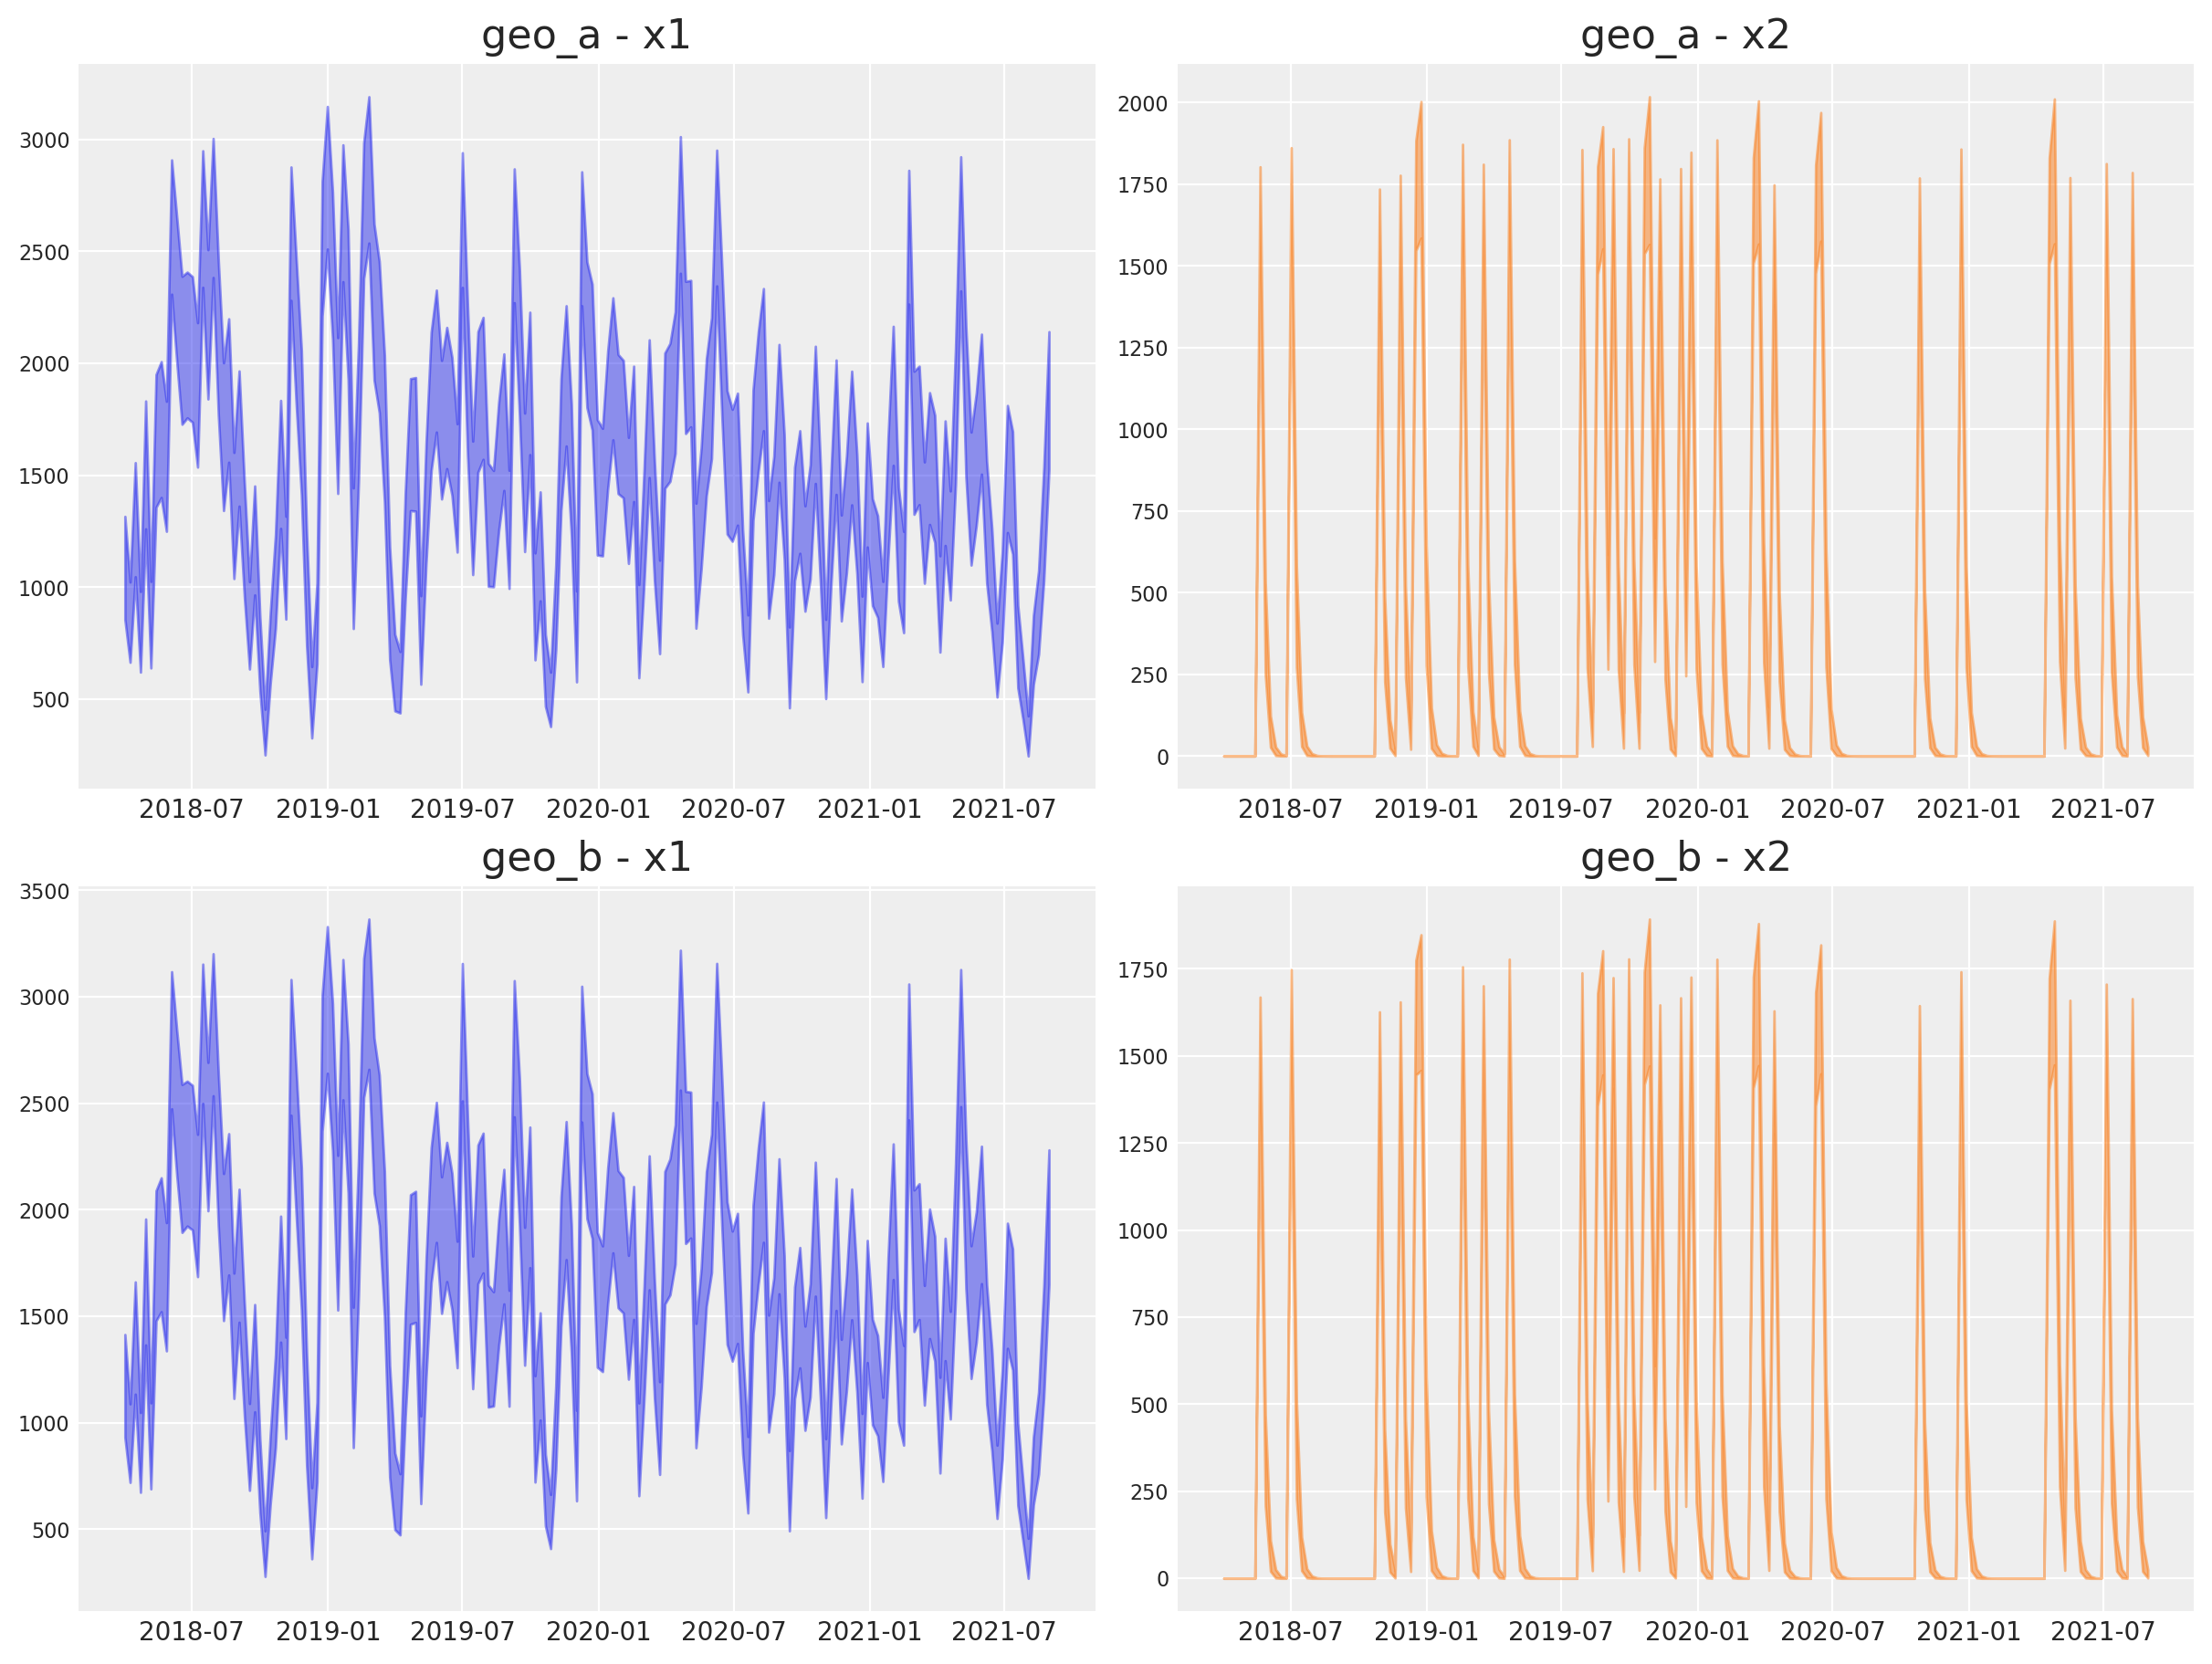

In [25]:
fig, axes = plt.subplots(
    nrows=len(mmm.model.coords["geo"]),
    ncols=len(mmm.model.coords["channel"]),
    figsize=(12, 9),
    layout="constrained",
)

for i, geo in enumerate(mmm.model.coords["geo"]):
    for j, channel in enumerate(mmm.model.coords["channel"]):
        ax = axes[i, j]
        az.plot_hdi(
            x=mmm.model.coords["date"],
            y=mmm.idata["posterior"]["channel_contribution_original_scale"].sel(
                geo=geo, channel=channel
            ),
            color=f"C{j}",
            smooth=False,
            hdi_prob=0.94,
            ax=ax,
        )
        ax.set_title(f"{geo} - {channel}")

Observe that all the vectorization and heavy lifting is done under the hood by the new class.

This new class has a new `plot` name space that contains many plotting methods. For example, we can reproduce the plots above by simply calling:

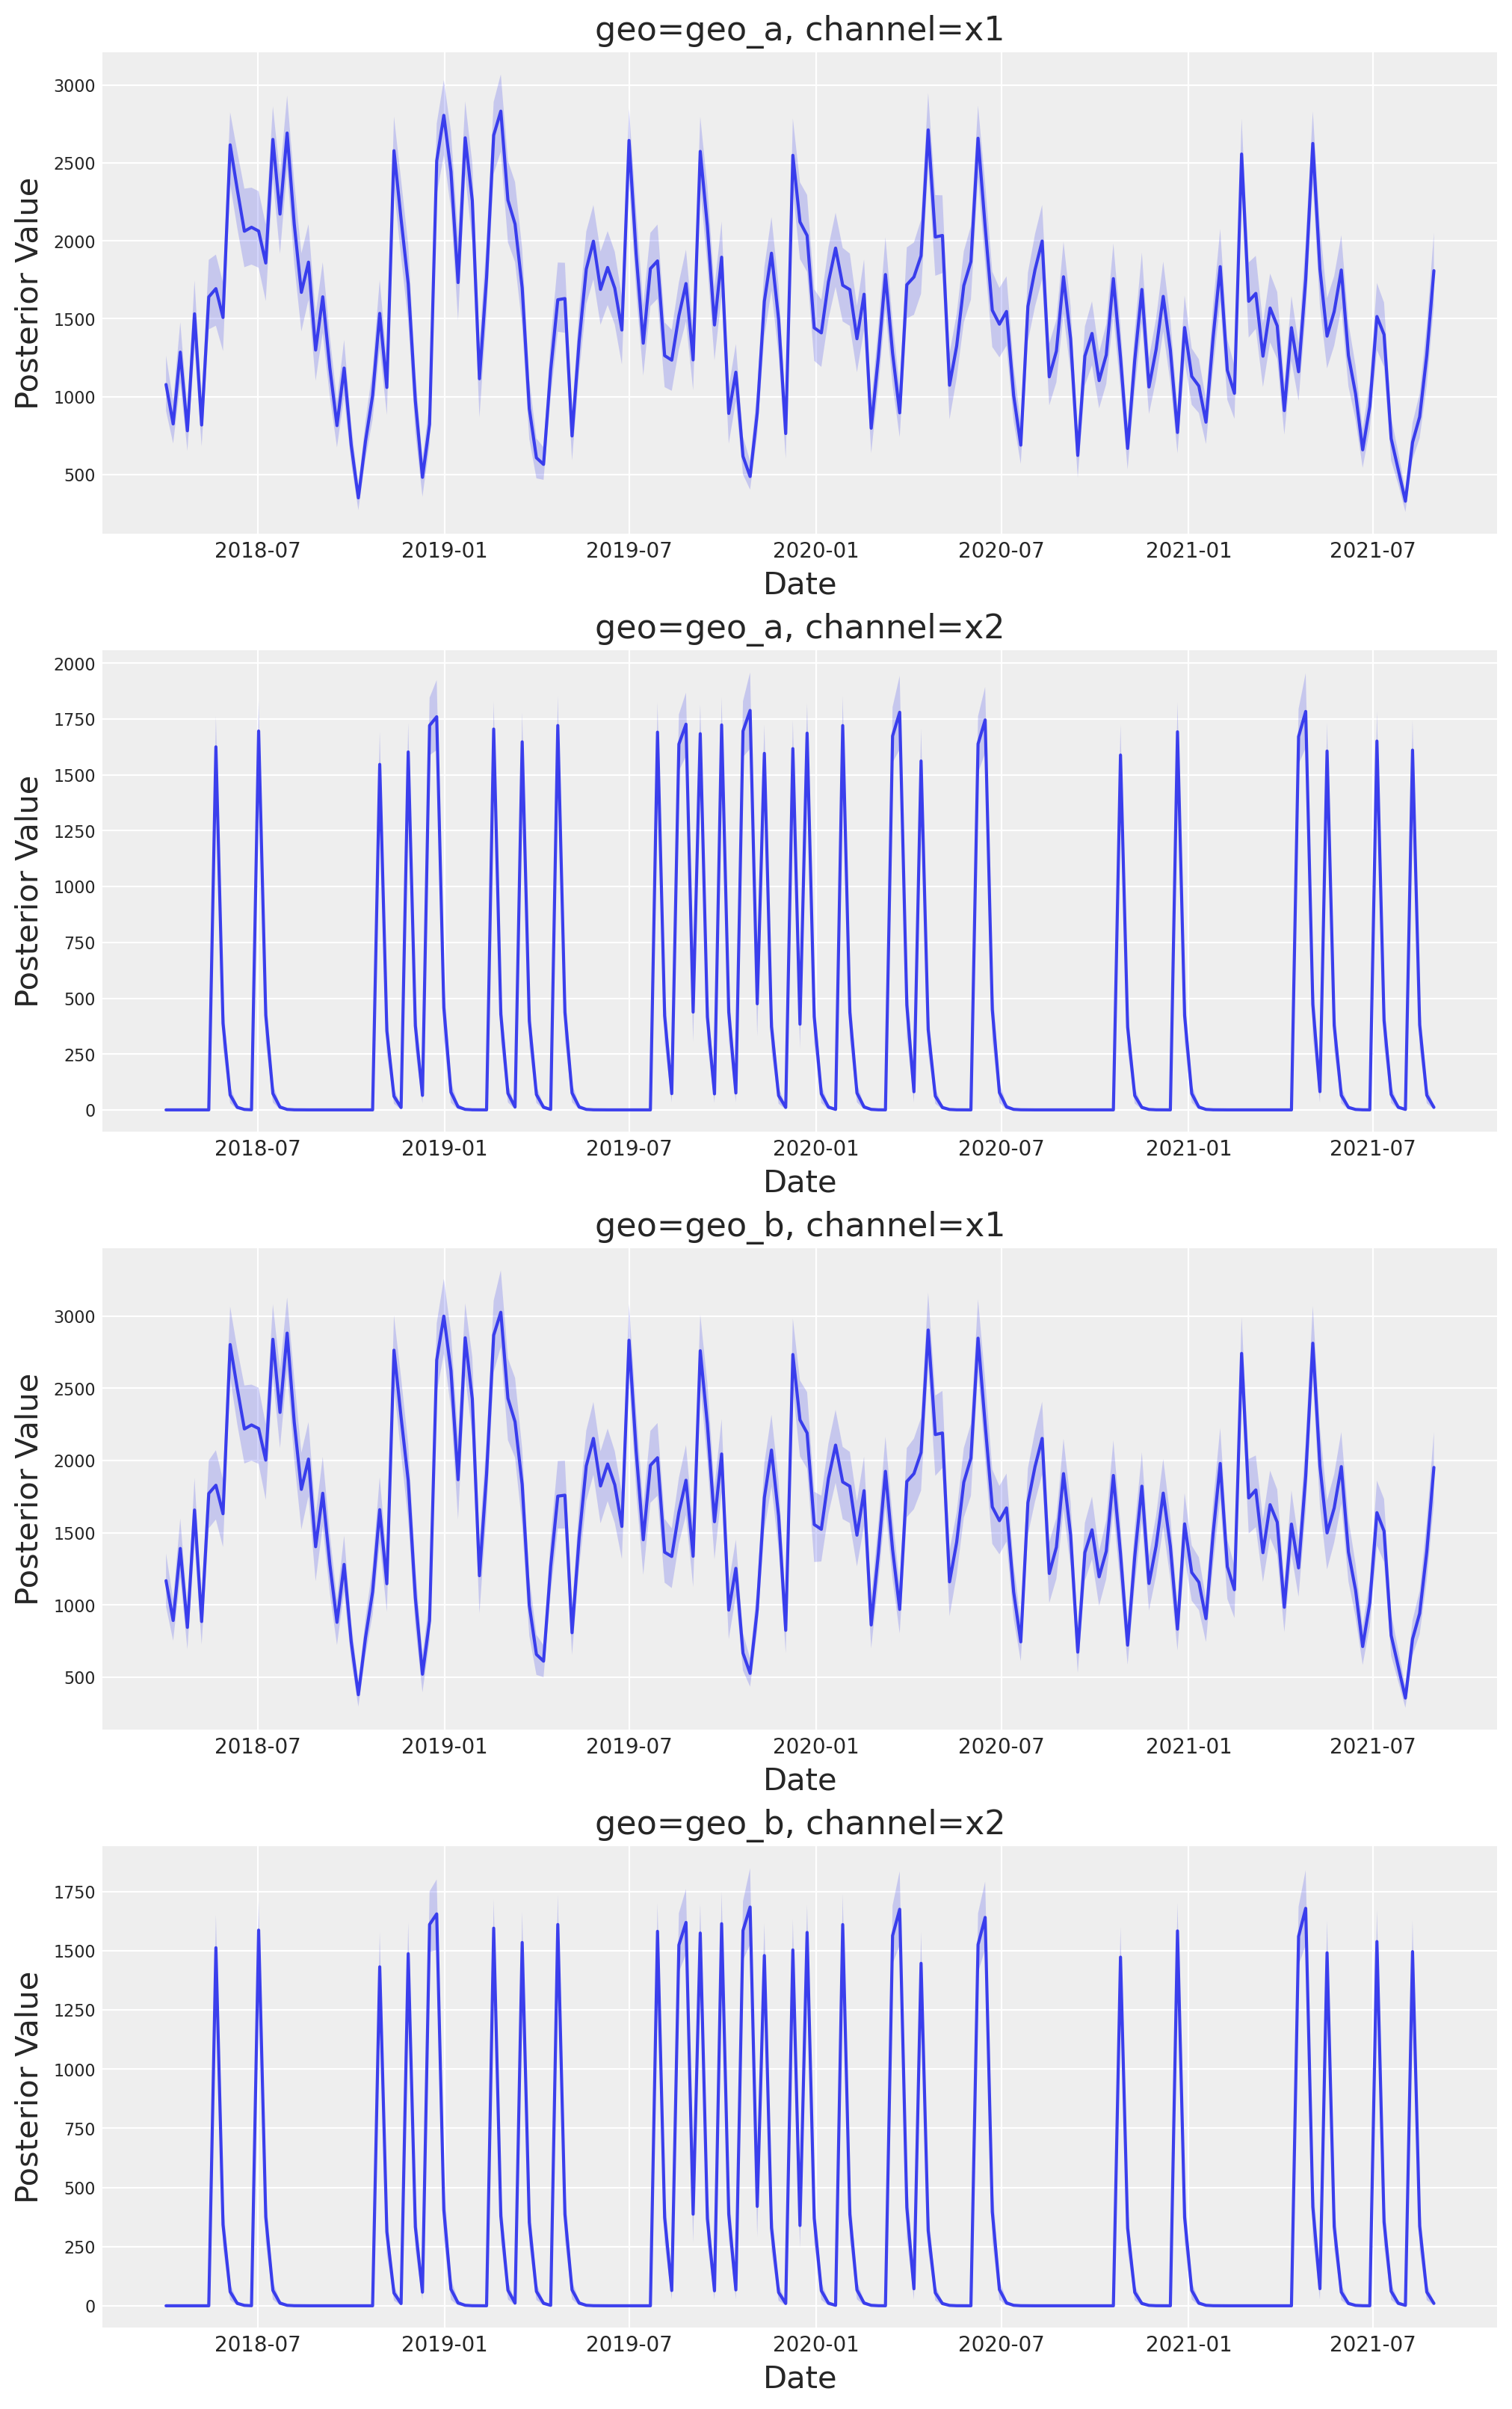

In [26]:
fig, axes = mmm.plot.contributions_over_time(
    var=["channel_contribution_original_scale"]
)

axes = axes.flatten()

for ax in axes:
    ax.legend().remove()

We can also plot the saturation curves for each channel and geo.

In [ ]:
mmm.plot.saturation_curves_scatter(
    width_per_col=8, height_per_row=4, original_scale=True
);

## Out of Sample Predictions

It is very important to be able to make predictions out of the sample. This is key for model validation, forward looking scenario planning and business decision making. Similarly as in the {ref}`mmm_example`, we assume the future spends are the same as the last day in the training sample. This way we can create a new dataset with the future dates and channel spends and use the model to make predictions.

In [ ]:
last_date = x_train["date"].max()

# New dates starting from last in dataset
n_new = 7
new_dates = pd.date_range(start=last_date, periods=1 + n_new, freq="W-MON")[1:]

x_out_of_sample_geo_a = pd.DataFrame({"date": new_dates, "geo": "geo_a"})
x_out_of_sample_geo_b = pd.DataFrame({"date": new_dates, "geo": "geo_b"})

# Same channel spends as last day
x_out_of_sample_geo_a["x1"] = x_train.query("geo == 'geo_a'")["x1"].iloc[-1]
x_out_of_sample_geo_a["x2"] = x_train.query("geo == 'geo_a'")["x2"].iloc[-1]

x_out_of_sample_geo_b["x1"] = x_train.query("geo == 'geo_b'")["x1"].iloc[-1]
x_out_of_sample_geo_b["x2"] = x_train.query("geo == 'geo_b'")["x2"].iloc[-1]

# Other features
## Event 1
x_out_of_sample_geo_a["event_1"] = 0.0
x_out_of_sample_geo_a["event_2"] = 0.0
## Event 2
x_out_of_sample_geo_b["event_1"] = 0.0
x_out_of_sample_geo_b["event_2"] = 0.0

x_out_of_sample = pd.concat([x_out_of_sample_geo_a, x_out_of_sample_geo_b])

# Final dataset to generate out of sample predictions.
x_out_of_sample

Using the same `sample_posterior_predictive` method, we can now generate the forecast.

In [ ]:
y_out_of_sample = mmm.sample_posterior_predictive(
    x_out_of_sample,
    extend_idata=False,
    include_last_observations=True,
    random_seed=rng,
)

y_out_of_sample

In [ ]:
fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12, 10),
    sharex=True,
    sharey=True,
    layout="constrained",
)

n_train_to_plot = 30

for ax, geo in zip(axes, mmm.model.coords["geo"], strict=True):
    for hdi_prob in [0.94, 0.5]:
        az.plot_hdi(
            x=mmm.model.coords["date"][-n_train_to_plot:],
            y=(
                mmm.idata["posterior_predictive"].sel(geo=geo)["y"][
                    :, :, -n_train_to_plot:
                ]
                * mmm.scalers["_target"].sel(geo=geo).item()
            ),
            color="C0",
            smooth=False,
            hdi_prob=hdi_prob,
            fill_kwargs={"alpha": 0.4, "label": f"{hdi_prob: 0.0%} HDI"},
            ax=ax,
        )

        az.plot_hdi(
            x_out_of_sample.query("geo == @geo")["date"],
            (
                y_out_of_sample["y"].sel(geo=geo).unstack().transpose(..., "date")
                * mmm.scalers["_target"].sel(geo=geo).item()
            ),
            color="C1",
            smooth=False,
            hdi_prob=hdi_prob,
            fill_kwargs={"alpha": 0.4, "label": f"{hdi_prob: 0.0%} HDI"},
            ax=ax,
        )

        ax.plot(
            x_out_of_sample.query("geo == @geo")["date"],
            y_out_of_sample["y"].sel(geo=geo).mean(dim="sample")
            * mmm.scalers["_target"].sel(geo=geo).item(),
            marker="o",
            color="C1",
            label="posterior predictive mean",
        )

    sns.lineplot(
        data=data_df.query("(geo == @geo)").tail(n_train_to_plot),
        x="date",
        y="y",
        marker="o",
        color="black",
        label="observed",
        ax=ax,
    )

    ax.axvline(x=last_date, color="gray", linestyle="--", label="last observation")
    ax.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        ncol=3,
    )
    ax.set(title=f"{geo}")

fig.suptitle(
    "Posterior Predictive - Out of Sample", fontsize=16, fontweight="bold", y=1.03
);

## Optimization

If you want to run optimizations, then you need to use the `MultiDimensionalBudgetOptimizerWrapper`.

In [ ]:
optimizable_model = MultiDimensionalBudgetOptimizerWrapper(
    model=mmm, start_date="2021-10-01", end_date="2021-12-31"
)

allocation_xarray, scipy_opt_result = optimizable_model.optimize_budget(
    budget=10,  # Total budget to allocate here is spend in Millions
)

sample_allocation = optimizable_model.sample_response_distribution(
    allocation_strategy=allocation_xarray,
)

This objects is an xarray dataset with the allocation and posterior predictive responses!

In [ ]:
sample_allocation

Once you get the allocation, you can plot a the results 🚀

In [ ]:
optimizable_model.plot.budget_allocation(
    samples=sample_allocation,
);

The graph shows the optimal budget for each channel on each geo, next to their respective mean contribution given the optimal budget. The method identify automatically the number of dimensions an tries to create a plot based on them.

If you want to see the full uncertanty over time, you can use the plot suite and the method `allocated_contribution_by_channel_over_time`.

In [ ]:
optimizable_model.plot.allocated_contribution_by_channel_over_time(
    samples=sample_allocation,
);

If you have a custom model, you can wrapped it into the model protocol, and use the optimizer after. If your model handle scales internally, you don't need to modify anything. Otherwise, for the plots, you may want to use `scale_factor=N`. E.g:

```python
optimizable_model.plot.budget_allocation(
    samples=sample_allocation,
    scale_factor=120
);
```

```{note}
We are very excited about this new feature and the possibilities it opens up. We are looking forward to hearing your feedback!
```

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc_marketing,pytensor,nutpie